<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
"""
PROJECT_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

PROJECT_PATH = 'gdrive/My Drive/Colab Notebooks/' 
"""

In [1]:
"""
ВСЕ ПОЯСНЕНИЯ, результаты и их описание - в файле TableResults.docx
Телеграм-бот (исходники)  - на гитхабе https://github.com/yukonta/EasyCaption 
Для экспериментов надо в данном ноутбуке изменить корневой каталог PROJECT_PATH на актуальный.
В каталог PROJECT_PATH скопировать каталог YukontaImgCaptioning, который лежит на гугл-диске 
по адресу https://drive.google.com/drive/folders/1QsTeeWrYbGPP5pWZ2Xlddcpc65FM5GVz?usp=sharing

Проведены эксперименты с двумя вариантами энкодера – InceptionV3 и Resnet50 
и с тремя вариантами датасета: MSCOCO2014, MSCOCO2017 (и подмножества), Flickr30k.
Все необходимое для экспериментов лежит на гугл-диске в каталоге YukontaImgCaptioning.
В подкаталоге YukontaImgCaptioning/DATAannotations находятся готовые файлы с captions 
и с картинками из перечисленных датасетов, преобразованными энкодерами (InceptionV3, Resnet50) 
(перечень файлов - в файле TableResults.docx).

Проведены эксперименты с предобученными эмбеддингами из Word2Vec. 

Проведены эксперименты с Attention. Для этого потребовалось создавать преобразованные энкодерами картинки формата 2048x8x8.

Ноутбук опционально предусматривает генерацию энкодерами (InceptionV3, Resnet50) из исходных наборов MSCOCO2017 и FLICKR30k -
файлов, содержащих преобразованные картинки форматов 2048 (вектор длины 2048) и 2048x8x8. Для генерации надо внутрь каталога  PROJECT_PATH поместить 
каталоги MSCOCO2017 (с подкаталогами data_train2017,data_val2017) и FLICKR30k с картинками из соответствующих датасетов
(датасеты MSCOCO2017 и FLICKR30k на моем гугл-диске не лежат (очень большие), их надо скачать с сайтов разработчиков этих датасетов).

В подкаталоге YukontaImgCaptioning/DATAannotations находятся также исходные файлы, использованные для построения датасетов:
Flickr30k_results.csv – файл с аннотациями датасета Flickr30k;
captions_train2017.json – файл, содержащий captions для MSCOCO2017/data_train2017;
captions_val2017.json – файл, содержащий captions для MSCOCO2017/data_val2017
"""

#https://github.com/dmitrii-davidov/ysda-deep-learning/blob/spring2019/homework04/beheaded_inception3.py
#https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py
#import torchvision.models as models
import nltk
import torch, torch.nn as nn
import torch.nn.functional as F
import time
import math
import random
import numpy as np
import pandas as pd
import os

import torchvision
from torchvision import transforms
#from torchvision.models import resnet50
from torchvision import models
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url
from torch.optim import lr_scheduler
from warnings import warn
import json

from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.color import gray2rgb
from skimage import img_as_ubyte
#from scipy.misc import imresize
%matplotlib inline
from tqdm.notebook import tnrange
from PIL import Image

# Корневой каталог проекта: PROJECT_PATH 
PROJECT_PATH = 'G:/Tanya/MIPT_T/_2 part/25_Proekt image_captionong/'

IMG_CAPTIONING_PATH = 'YukontaImgCaptioning/'

DATA_PATH_MSCOCO2017 = 'MSCOCO2017/' # каталог с датасетом MSCOCO2017 (на гугл диске нету, надо скачать на сайте разработчика)
DATA_PATH_FLICKR30k =  'FLICKR30k/'   # каталог с датасетом FLICKR30k (на гугл диске нету, надо скачать на сайте разработчика)

DATA_PATH_ANNOTATIONS = IMG_CAPTIONING_PATH + 'DATAannotations/' # каталог со всеми аннотациями 
                            #(в него записываются создаваемые файлы с captions  и с пропущенными через энкодер картинками)
                
DATA_PATH_MSCOCO2014_ANNOTATIONS = DATA_PATH_ANNOTATIONS + 'MSCOCO2014/handout/data/'  # каталог с данными из бейзлайна MSCOCO2014

DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all = DATA_PATH_MSCOCO2017 + 'img8x8_MSCOCO2017_all/'  # каталог, куда записываются преобразованные к 8x8x2048 отдельные файлы картинок из полного датасета MSCOCO2017
DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_val = DATA_PATH_MSCOCO2017 + 'img8x8_MSCOCO2017_val/'  # каталог, куда записываются преобразованные к 8x8x2048 отдельные файлы картинок из датасета MSCOCO2017-VAL(5000 картинок)
DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_20000 = DATA_PATH_MSCOCO2017 + 'img8x8_MSCOCO2017_20000/' # каталог, куда записываются преобразованные к 8x8x2048 отдельные файлы картинок из выборки 20000 картинок из датасета MSCOCO2017
DATA_PATH_MSCOCO2017_img8x8_flickr30k = DATA_PATH_FLICKR30k + 'img8x8_flickr30k/'# каталог, куда записываются преобразованные к 8x8x2048 отдельные файлы картинок из датасета flickr30k

NET_SAVE_DIR = IMG_CAPTIONING_PATH  # каталог, куда сохраняются веса модели
IMG_TEST_DIR = IMG_CAPTIONING_PATH + 'Pictures/' # каталог с картинками для тестов

# Выбор датасета
MSCOCO2014 = 0 #  флаг - датасет, который был в бейзлайне
MSCOCO2017 = 1 #  флаг - датасет MSCOCO2017
MSCOCO2017_VAL = 11 #  флаг - датасет MSCOCO2017_VAL
MSCOCO2017_20000 = 12 #  флаг - датасет MSCOCO2017_20000
FLICKR30k = 2  #  флаг - датасет FLICKR30k

# Выбор энкодера
NET_TYPE_INCEPTION3 = 0 # тип энкодера - InceptionV3
NET_TYPE_RESNET50 = 1 # тип энкодера - Resnet50

# Выбор формата пробразованных энкодером картинок. 
# Преобразованные энкодером картинки формата 2048 сохраняются сначала в массиве, потом массив записывается на диск в файл 
# с именем (отражающим название датасета и энкодера) и расширением .npy.
# Для преобразованных (только энкодером  InceptionV3) картинок формата 2048x8x8 предусмотрены два варианта:
# - если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то картинки формата 2048x8x8 сохраняются сначала в массиве, потом массив записывается на диск в файл 
# с именем (отражающим название датасета, энкодера и формата 2048x8x8) и расширением .npy записывается в файл;
# - если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то каждая картинка формата 2048x8x8 записывается в отдельный файл 
# в каталог из вышереречисленных (DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all и т.п.) 
# с именем файла <имя файла исходной картинки>.npy.

IMAGES_FORMAT_1x2048 = 0    # флаг - формат картинок 1x2048
IMAGES_FORMAT_2048x8x8_IN_MEMORY = 1  # флаг -формат картинок 2048x8x8, сохраняются в массиве (в оперативной памяти)
IMAGES_FORMAT_2048x8x8_IN_FILES = 2  # флаг -формат картинок 2048x8x8, сохраняются на диске
# Примечание - Если датасет - MSCOCO2017 (весь), то массив преобразованных картинок в памяти не помещается, поэтому 
"""
dataset_type = MSCOCO2017 # Выбор типа датасета, который будем использовать
net_enc_type = NET_TYPE_INCEPTION3
make_new_dataset = False # Если запускаем первый раз, то составляем датасет из исходных файлов и записываем в файлы img_codes и captions,
                        # если запускаем не в первый раз, то img_codes и captions считываем из готовых файлов
images_format = IMAGES_FORMAT_1x2048
"""
dataset_type = MSCOCO2017 # Выбор типа датасета, который будем использовать
net_enc_type = NET_TYPE_INCEPTION3 # выбор энкодера
images_format = IMAGES_FORMAT_1x2048 # выбор формата преобразования картнок
make_new_dataset = False # Если запускаем первый раз, то составляем датасет из исходных файлов и записываем в файлы img_codes и captions,
                        # если запускаем не в первый раз, то img_codes и captions считываем с диска из готовых файлов

os.chdir(PROJECT_PATH)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 2048 x 8 x 8
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url, progress=False))
    return model

class EncoderCNN_Resnet50(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN_Resnet50, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.embed_size = embed_size
        
        self.transform_input = True

    def forward(self, images):
        if self.transform_input:
            images = images.clone()
            images[:, 0] = images[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            images[:, 1] = images[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            images[:, 2] = images[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")        
        #print('images.shape=',images.shape) #torch.Size([64, 3, 224, 224])
        features = self.resnet(images)
        #print('before view(features.size(0), -1)::: features.shape=',features.shape) #torch.Size([64, 2048, 1, 1])
        features = features.view(features.size(0), -1)
        #print('after view(features.size(0), -1)::: features.shape=',features.shape) #torch.Size([64, 2048])
        if (self.embed_size != 2048):
            features = self.embed(features)
        #print('after embed::: features.shape=',features.shape) #torch.Size([64, 300])  
        return features, features, features


In [4]:
assert net_enc_type == NET_TYPE_INCEPTION3 or net_enc_type == NET_TYPE_RESNET50, 'Unknown type of Encoder'

# Если images_format равен IMAGES_FORMAT_2048x8x8_IN_MEMORY или IMAGES_FORMAT_2048x8x8_IN_FILES,
# то все равно на диске создается файл с картинками формата 2048 (векторы длиной 2048) (заодно - поскольку InceptionV3 
# выдает картики в этом формате вместе с картинками формата 2048x8x8)
# Если images_format равен IMAGES_FORMAT_2048x8x8_IN_MEMORY или IMAGES_FORMAT_2048x8x8_IN_FILES, то          
#  net_enc_type присваивается NET_TYPE_INCEPTION3 (поскольку Resnet50 в данном варианте не выдает формат 2048x8x8)
# Если net_enc_type равен NET_TYPE_RESNET50, то images_format присваивается IMAGES_FORMAT_1x2048 (см. в коде программы)
#(поскольку Resnet50 в данном варианте не выдает формат 2048x8x8)
# Если dataset_type равен MSCOCO2014, то  images_format присваивается IMAGES_FORMAT_1x2048  (см. в коде программы)
#(поскольку картинки формата 2048 были в бейзлайне) и датасет MSCOCO2014 я не скачивала (т.е. сейчас нет оригиналов картинок)
# Если dataset_type равен MSCOCO2017 and images_format равен IMAGES_FORMAT_2048x8x8_IN_MEMORY, то
# images_format присваивается IMAGES_FORMAT_2048x8x8_IN_FILES (см. в коде программы)(потому что картинки формата 2048x8x8 из MSCOCO2017 не поместится в массив)

if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:    
    if(net_enc_type == NET_TYPE_RESNET50):
        print ('images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, that is why encoder type changed from Resnet50 to InceptionV3, because Resnet50 can not make 2048x8x8')
    net_enc_type = NET_TYPE_INCEPTION3  # поскольку Resnet50 в данном варианте не выдает формат 2048x8x8
    
if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:     
    if(net_enc_type == NET_TYPE_RESNET50):
        print ('images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, that is why encoder type changed from Resnet50 to InceptionV3, because Resnet50 can not make 2048x8x8')
    net_enc_type = NET_TYPE_INCEPTION3  # поскольку Resnet50 в данном варианте не выдает формат 2048x8x8
    
if net_enc_type == NET_TYPE_RESNET50:
    print ('net_enc_type == NET_TYPE_RESNET50, that is why images_format set to 1x2048, because Resnet50 can not make 2048x8x8')
    images_format = IMAGES_FORMAT_1x2048 # потому что в данном варианте Resnet50 не препобразует в формат 2048x8x8
    
if dataset_type == MSCOCO2014:
    print ('dataset_type == MSCOCO2014, that is why images_format set to 1x2048, because we do not have source files for MSCOCO2014 in order to make format 2048x8x8')    
    images_format = IMAGES_FORMAT_1x2048 # потому что для MSCOCO2014 имеются в наличии преобразованные картинки формата 1x2048, а исходные картинки я не скачивала
    
if dataset_type == MSCOCO2017 and images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
    print ('dataset_type == MSCOCO2017 and images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY,\n but images in format 2048x8x8 will be saved in files because there not enouth memory for MSCOCO2017')    
    images_format = IMAGES_FORMAT_2048x8x8_IN_FILES # потому что такой большой датасет формата 2048x8x8 не поместится в массив

if net_enc_type == NET_TYPE_INCEPTION3:
    const_resize = 299
    model_enc = beheaded_inception_v3().to(device)
    fname_model = '_incept3'
elif net_enc_type == NET_TYPE_RESNET50:
    const_resize = 224
    model_enc = EncoderCNN_Resnet50(embed_size=2048).to(device)
    fname_model = '_resnet50'

model_enc.eval()

BeheadedInception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine

In [5]:
# загружаем или создаем датасет

# Если dataset_type == MSCOCO2014, то 
#1) captions загружаются из файла 'captions_tokenized.json' в массив. 
#2) картинки формата 2048, подготовленные энкодером InceptionV3, загружаются из файла 'image_codes.npy' в массив;
# (каталоги для файлов указаны коде программы)

# Если dataset_type == MSCOCO2017 и его подмножества ( MSCOCO2017_2000 из 20000 картинок,  MSCOCO2017_VAL из 5000 картинок), то: 
# I) Если  make_new_dataset == True, то создаем из исходных картинок датасет с captions и с преобразованными картинками:
#   1) Формируем массив captions из файлов captions_train2017.json и captions_val2017.json и записываем массив в файл
#     captions_tokenized_MSCOCO2017.json (или в captions_tokenized_MSCOCO2017_2000.json, captions_tokenized_MSCOCO2017_val.json для соответствующих подмножеств)
#    (в captions записываем заголовки из обоих исходных файлов .json, потом cами поделим на train и val).
#   2) Формируем массив img_codes (преобразованные энкодером в формат 2048 картинки из исходных датасетов) 
#      и записываем его в файл 'image_codes_MSCOCO2017' + fname_model +'.npy' (или 'image_codes_MSCOCO2017_2000' + fname_model +'.npy', 'image_codes_MSCOCO2017_val' + fname_model +'.npy' для соответствующих подмножеств).
#   3) Если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то (только для энкодера InceptionV3) 
#      пропущенные через энкодер картинки формата 2048x8x8 записываем в соответствующий каталог 
#      в отдельные файлы с именами исходных картинок и расширннием .npy. Тогда в массив img_codes2048x8x8 записываем 
#      имена исходных файлов-картинок из датасета  (потом при тренировке и валидации будем формировать батчи картинок с именами из этого массива, заменяя расширения на .npy).
#   4) Eсли images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то (только для энкодера InceptionV3 
#      и только для подмножеств MSCOCO2017_2000 из 20000 картинок в MSCOCO2017_VAL, потому что весь MSCOCO2017 слишком большой - все картинки формата 2048x8x8 в память не поместятся ) 
#      пропущенные через энкодер картинки формата 2048x8x8 записываем в массив img_codes2048x8x8 и затем массив записываем в файл
#      'image_codes_MSCOCO2017_2000_incept3_2048x8x8.npy' или 'image_codes_MSCOCO2017_val_incept3_2048x8x8.npy'.
#      
#  II) если  make_new_dataset == False, то загружаем датасет из ранее созданных файлов:
#    1) captions загружаются в массив captions из файла captions_tokenized_MSCOCO2017.json (или captions_tokenized_MSCOCO2017_2000.json, captions_tokenized_MSCOCO2017_val.json для соответствующих подмножеств).
#    2) Картинки формата 2048 загружаются в массив img_codes из файла 'image_codes_MSCOCO2017' + fname_model +'.npy' (или 'image_codes_MSCOCO2017_2000' + fname_model +'.npy', 'image_codes_MSCOCO2017_val' + fname_model +'.npy' для соответствующих подмножеств)
#    3) Если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то в массив img_codes2048x8x8 записываем имена файлов-картинок датасета (потом при тренировке и валидации будем формировать батчи картинок с именами из этого массива, заменяя расширения на .npy).
#    4) Если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то картинки формата 2048x8x8 загружаются в массив img_codes2048x8x8 
#       из файла 'image_codes_MSCOCO2017_2000_incept3_2048x8x8.npy' или 'image_codes_MSCOCO2017_val_incept3_2048x8x8.npy'.
# (!!!!!!!!!! Каталоги для файлов указаны коде программы ).
#
# Если dataset_type == FLICKR30k, то: 
# I) Если  make_new_dataset == True, то создаем из исходных картинок датасет с captions и с преобразованными картинками:
#   1) Формируем массив captions из содержимого колонки 'comment' в файле Flickr30k_results.csv (содержащем аннотации датасета Flickr30k).
#      (в файл массив captions не записываем, его легко формировать из Flickr30k_results.csv).
#   2) Формируем массив img_codes (преобразованные энкодером в формат 2048 картинки из датасета Flickr30k) 
#      и записываем его в файл 'image_codes_Flickr30k' + fname_model +'.npy' .
#   3) Если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то (только для энкодера InceptionV3) 
#      пропущенные через энкодер картинки формата 2048x8x8 записываем в соответствующий каталог 
#      в отдельные файлы с именами исходных картинок и расширннием .npy. Тогда в массив img_codes2048x8x8 записываем 
#      имена исходных файлов-картинок из датасета  (потом при тренировке и валидации будем формировать батчи картинок с именами из этого массива, заменяя расширения на .npy).
#   4) Eсли images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то (только для энкодера InceptionV3)
#      пропущенные через энкодер картинки формата 2048x8x8 записываем в массив img_codes2048x8x8 и затем массив записываем в файл
#      'image_codes_Flickr30k_incept3_2048x8x8.npy'.
#      
#  II) если  make_new_dataset == False, то загружаем датасет из ранее созданных файлов:
#    1) Формируем массив captions из содержимого колонки 'comment' в файле Flickr30k_results.csv (содержащем аннотации датасета Flickr30k).
#    2) картинки формата 2048 загружаются в массив img_codes из файла 'image_codes_MSCOCO2017' + fname_model +'.npy' (или 'image_codes_MSCOCO2017_2000' + fname_model +'.npy', 'image_codes_MSCOCO2017_val' + fname_model +'.npy' для соответствующих подмножеств)
#    3) если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то в массив img_codes2048x8x8 записываем имена файлов-картинок датасета (потом при тренировке и валидации будем формировать батчи картинок с именами из этого массива, заменяя расширения на .npy).
#    4) если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то картинки формата 2048x8x8 загружаются в массив img_codes2048x8x8 из
#       файла 'image_codes_Flickr30k_incept3_2048x8x8.npy'.
#
# (!!!!!!!!!! Каталоги для файлов указаны коде программы ).


assert dataset_type in [MSCOCO2014, MSCOCO2017, MSCOCO2017_VAL, MSCOCO2017_20000, FLICKR30k], 'Unknown dataset_type'
assert net_enc_type in [NET_TYPE_INCEPTION3 , NET_TYPE_RESNET50], 'Unknown type of Encoder'

img_codes2048x8x8 = None
    
if dataset_type == MSCOCO2014:
    img_codes = np.load(DATA_PATH_MSCOCO2014_ANNOTATIONS + 'image_codes.npy')
    captions = json.load(open(DATA_PATH_MSCOCO2014_ANNOTATIONS + 'captions_tokenized.json'))

elif dataset_type == MSCOCO2017:
    if make_new_dataset:
        if not os.path.exists(DATA_PATH_ANNOTATIONS): 
            os.makedirs(DATA_PATH_ANNOTATIONS)         
        file_list_train = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_train2017'))
        file_list_val = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_val2017'))
        captions_train_orig = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_train2017.json'))    
        captions_val_orig = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_val2017.json')) 
        
        print('len(captions_train_orig[annotations])=', len(captions_train_orig['annotations']))
        print('len(captions_val_orig[annotations])=', len(captions_val_orig['annotations']))
       
        captions = []
       
        for f in file_list_train:
            img = list(filter(lambda x: x['file_name'] == f, captions_train_orig['images']))[0]
            cap = list(filter(lambda x: x['image_id'] == img['id'], captions_train_orig['annotations']))
            captions.append([c['caption'] for c in cap])
            img = None
            cap = None
        
        for f in file_list_val:
            img = list(filter(lambda x: x['file_name'] == f, captions_val_orig['images']))[0]
            cap = list(filter(lambda x: x['image_id'] == img['id'], captions_val_orig['annotations']))
            captions.append([c['caption'] for c in cap])
            img = None
            cap = None
            
        captions_train_orig = None
        captions_val_orig = None
        
        print('len(captions)=', len(captions))
        print(list(set([len(cap) for cap in captions])))

        with open(os.path.join(DATA_PATH_ANNOTATIONS + 'captions_tokenized_MSCOCO2017.json'), 'w') as f:
            json.dump(captions, f)
       
        # формируем массив img_codes с закодированными картинками формата 1х2048 и сохраняем его в файл
        # если для аттеншена нужны картинки 2048x8x8 (их тоже делает сеть InseptiomV3), то каждую такую картинку 2048x8x8
        # сохраняем в отдельный файл. В массив img_codes2048x8x8 записываем имена файлов с преобразованными картинками.
        if (images_format == IMAGES_FORMAT_2048x8x8_IN_FILES) and (not os.path.exists(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all)): 
            os.makedirs(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all)         

        img_codes = np.zeros((len(file_list_train)+len(file_list_val), 2048), dtype=np.float32) # к-во картинок x 2048 - Массив преобразованных картинок
        for i in tnrange(len(file_list_train)):
            im = plt.imread(DATA_PATH_MSCOCO2017 + 'data_train2017/' + file_list_train[i]) # читаем картинку из файла
            if (len(im.shape) == 2): # если картинка черно-белая
                im = gray2rgb(im)    
            #print(i, im.shape)
            im = resize(im, (const_resize, const_resize))                
            img_tensor = torch.tensor(im.transpose([2, 0, 1]), dtype=torch.float32).to(device)
            #print('before unsqueeze(0): img_tensor.shape=',img_tensor.shape) #torch.Size([3, 224, 224])
            x_for_attn, x_for_capt_2048, _ = model_enc(img_tensor.unsqueeze(0)) #(img_tensor[None]) #пропускаем картинку через энкодер
            #rint('x_for_attn.shape=', x_for_attn.shape) #torch.Size([2048x8x8])
            #print('x_for_capt_2048.shape=',x_for_capt_2048.shape) #torch.Size([1, 2048])            
            img_codes[i, :] = x_for_capt_2048.detach().cpu().numpy()            
            if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
                #сохраняем преобразованную картинку формата 2048x8x8 в файл 
                np.save(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all + file_list_train[i][:-4] +'.npy', x_for_attn.detach().cpu().numpy())
            img_tensor = None
            im = None

        l = len(file_list_train)    
        for i in tnrange(len(file_list_val)):
            im = plt.imread(DATA_PATH_MSCOCO2017 + 'data_val2017/'+ file_list_val[i])
            im = resize(im, (const_resize, const_resize))
            if (len(im.shape) == 2):
                im = gray2rgb(im)    
            img_tensor = torch.tensor(im.transpose([2, 0, 1]), dtype=torch.float32).to(device)
            x_for_attn, x_for_capt_2048, _ = model_enc(img_tensor.unsqueeze(0)) #(img_tensor[None])
            img_codes[l+i, :] = x_for_capt_2048.detach().cpu().numpy()
            if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
                np.save(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all + file_list_val[i][:-4] +'.npy', x_for_attn.detach().cpu().numpy())                
            img_tensor = None
            im = None   

        np.save(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017' + fname_model +'.npy', img_codes)
        # засунуть в память все картинки из MSCOCO2017 формата 2048x8x8 невозможно, поэтому:
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            images_format = IMAGES_FORMAT_2048x8x8_IN_FILES
        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            img_codes2048x8x8 = np.array(file_list_train + file_list_val)
           

    else:  #not make_new_dataset MSCOCO2017
        captions = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_tokenized_MSCOCO2017.json'))   
        img_codes = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017' + fname_model +'.npy')
        print('img_codes.shape=',img_codes.shape)
        # засунуть в память все картинки из MSCOCO2017 формата 2048x8x8 невозможно, поэтому:
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            images_format = IMAGES_FORMAT_2048x8x8_IN_FILES        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            file_list_train = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_train2017'))
            file_list_val = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_val2017'))                        
            img_codes2048x8x8 = np.array(file_list_train + file_list_val)

    file_list_train = None 
    file_list_val = None            
    
elif dataset_type == MSCOCO2017_VAL:
    if make_new_dataset:
        if not os.path.exists(DATA_PATH_ANNOTATIONS): 
            os.makedirs(DATA_PATH_ANNOTATIONS)         
        
        file_list_val = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_val2017'))

        captions_val_orig = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_val2017.json')) 
        print('len(captions_val_orig[annotations])=', len(captions_val_orig['annotations']))
       
        captions = []
        for f in file_list_val:
            img = list(filter(lambda x: x['file_name'] == f, captions_val_orig['images']))[0]
            cap = list(filter(lambda x: x['image_id'] == img['id'], captions_val_orig['annotations']))
            captions.append([c['caption'] for c in cap])
            img = None
            cap = None
            
        captions_val_orig = None
        print('len(captions)=', len(captions))
        print(list(set([len(cap) for cap in captions])))
        with open(os.path.join(DATA_PATH_ANNOTATIONS + 'captions_tokenized_MSCOCO2017_val.json'), 'w') as f:
            json.dump(captions, f)
       
        # формируем массив img_codes с закодированными картинками формата 1х2048 и сохраняем его в файл
        # если для аттеншена нужны картинки 2048x8x8 (их тоже делает сеть InseptiomV3), то:
        # если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то формируем массив img_codes2048x8x8
        # с закодированными картинками формата 2048x8x8 и тоже сохраняем его в файл
        # если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, (их тоже делает сеть InseptiomV3), 
        # то каждую такую картинку 2048x8x8 сохраняем в отдельный файл,тогда в img_codes2048x8x8 будут имена файлов с преобразованными картинками        
        
        if (images_format == IMAGES_FORMAT_2048x8x8_IN_FILES) and (not os.path.exists(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_val)): 
            os.makedirs(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_val)         
        img_codes = np.zeros((len(file_list_val), 2048), dtype=np.float32)
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            img_codes2048x8x8 = np.zeros((len(file_list_val), 2048, 8, 8), dtype=np.float32)
        for i in tnrange(len(file_list_val)):
            im = plt.imread(DATA_PATH_MSCOCO2017 + 'data_val2017/'+ file_list_val[i])
            im = resize(im, (const_resize, const_resize))
            if (len(im.shape) == 2):
                im = gray2rgb(im)    
            img_tensor = torch.tensor(im.transpose([2, 0, 1]), dtype=torch.float32).to(device)
            #print('img_tensor.shape=',img_tensor.shape) #torch.Size([3, 299, 299])
            x_for_attn, x_for_capt_2048, _ = model_enc(img_tensor.unsqueeze(0)) #(img_tensor[None])
            img_codes[i, :] = x_for_capt_2048.detach().cpu().numpy()
            if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
                img_codes2048x8x8[i, :] = x_for_attn.detach().cpu().numpy()
            elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
                np.save(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_val + file_list_val[i][:-4] +'.npy', x_for_attn.detach().cpu().numpy())                
            img_tensor = None
            im = None   

        np.save(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_val' + fname_model +'.npy', img_codes)
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            np.save(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_val' + fname_model +'_2048x8x8.npy', img_codes2048x8x8)
        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            img_codes2048x8x8 = np.array(file_list_val)
           
        
    else:  #not make_new_dataset MSCOCO2017_VAL
        captions = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_tokenized_MSCOCO2017_val.json'))   
        img_codes = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_val' + fname_model +'.npy')
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:        
            img_codes2048x8x8 = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_val' + fname_model +'_2048x8x8.npy')
        elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            file_list_val = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_val2017'))            
            img_codes2048x8x8 = np.array(file_list_val)        
   
    file_list_val = None                      


elif dataset_type == MSCOCO2017_20000:
    if make_new_dataset:
        if not os.path.exists(DATA_PATH_ANNOTATIONS): 
            os.makedirs(DATA_PATH_ANNOTATIONS)         
        
        file_list_train = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_train2017'))
        file_list_train = file_list_train[:20000]
        print('len(file_list_train)=', len(file_list_train))
        
        captions_train_orig = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_train2017.json')) 
        print('len(captions_train_orig[annotations])=', len(captions_train_orig['annotations']))
       
        captions = []
        for f in file_list_train:
            img = list(filter(lambda x: x['file_name'] == f, captions_train_orig['images']))[0]
            cap = list(filter(lambda x: x['image_id'] == img['id'], captions_train_orig['annotations']))
            captions.append([c['caption'] for c in cap])
            img = None
            cap = None
            
        captions_train_orig = None

        print('len(captions)=', len(captions))
        print(list(set([len(cap) for cap in captions])))
        with open(os.path.join(DATA_PATH_ANNOTATIONS + 'captions_tokenized_MSCOCO2017_20000.json'), 'w') as f:
            json.dump(captions, f)
       
    
        # формируем массив img_codes с закодированными картинками формата 1х2048 и сохраняем его в файл
        # если для аттеншена нужны картинки 2048x8x8 (их тоже делает сеть InseptiomV3), то:
        # если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то формируем массив img_codes2048x8x8
        # с закодированными картинками формата 2048x8x8 и тоже сохраняем его в файл
        # если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, (их тоже делает сеть InseptiomV3), 
        # то каждую такую картинку 2048x8x8 сохраняем в отдельный файл,тогда в img_codes2048x8x8 будут имена файлов с преобразованными картинками        
        if (images_format == IMAGES_FORMAT_2048x8x8_IN_FILES) and (not os.path.exists(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_20000)): 
            os.makedirs(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_20000)                 
        img_codes = np.zeros((20000, 2048), dtype=np.float32)
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            img_codes2048x8x8 = np.zeros((20000, 2048, 8, 8), dtype=np.float32)
        for i in tnrange(len(file_list_train)):
            im = plt.imread(DATA_PATH_MSCOCO2017 + 'data_train2017/'+ file_list_train[i])
            im = resize(im, (const_resize, const_resize))
            if (len(im.shape) == 2):
                im = gray2rgb(im)    
            img_tensor = torch.tensor(im.transpose([2, 0, 1]), dtype=torch.float32).to(device)
            #print('img_tensor.shape=',img_tensor.shape) #torch.Size([3, 299, 299])
            x_for_attn, x_for_capt_2048, _ = model_enc(img_tensor.unsqueeze(0)) #(img_tensor[None])
            img_codes[i, :] = x_for_capt_2048.detach().cpu().numpy()
            if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
                img_codes2048x8x8[i, :] = x_for_attn.detach().cpu().numpy()
            elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
                np.save(DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_20000 + file_list_val[i][:-4] +'.npy', x_for_attn.detach().cpu().numpy())                
            img_tensor = None
            im = None   

        np.save(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_20000' + fname_model +'.npy', img_codes)
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            np.save(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_20000' + fname_model +'_2048x8x8.npy', img_codes2048x8x8)
        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            img_codes2048x8x8 = np.array(file_list_train)
           
        
    else:  #not make_new_dataset MSCOCO2017_TRAIN2000
        captions = json.load(open(DATA_PATH_ANNOTATIONS + 'captions_tokenized_MSCOCO2017_20000.json'))   
        img_codes = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_20000' + fname_model +'.npy')
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:        
            img_codes2048x8x8 = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_MSCOCO2017_20000' + fname_model +'_2048x8x8.npy')
        elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            file_list_train = os.listdir(os.path.join(DATA_PATH_MSCOCO2017, 'data_train2017'))  
            file_list_train = file_list_train[:20000]
            img_codes2048x8x8 = np.array(file_list_train)        
   
    file_list_train = None                      

elif dataset_type == FLICKR30k: 
    if not os.path.exists(DATA_PATH_ANNOTATIONS): 
        os.makedirs(DATA_PATH_ANNOTATIONS)         
    
    data_flickr30k = pd.read_csv(DATA_PATH_ANNOTATIONS + 'Flickr30k_results.csv', sep='|', index_col=None)
    #data_flickr30k.head()
    print('data_flickr30k.shape', data_flickr30k.shape)

    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    data_flickr30k[' comment;'] = data_flickr30k[' comment;'].apply(lambda l: (' '.join(tokenizer.tokenize(str(l).lower()))) + ' .')

    i = 0
    n_in_data = i
    img_filenames_flickr30k = []
    captions = []
    while n_in_data < len(data_flickr30k):
        img_filenames_flickr30k.append(data_flickr30k['image_name'][n_in_data])
        capt = []
        capt.append(data_flickr30k[' comment;'][n_in_data]) 
        n_in_data += 1
        while (n_in_data < len(data_flickr30k)) and (int(data_flickr30k[' comment_number'][n_in_data]) > 0):
            capt.append(data_flickr30k[' comment;'][n_in_data])  
            n_in_data += 1
        captions.append(capt)
        capt = None
        i += 1
    
    print('len(img_filenames_flickr30k)=', len(img_filenames_flickr30k), 'len(captions_flickr30k)=', len(captions))
    print(img_filenames_flickr30k[0:5])
    print('\n'.join(captions[0]))
    print('\n')
    print('\n'.join(captions[1]))

    image = plt.imread(DATA_PATH_FLICKR30k + 'flickr30k_images/' + img_filenames_flickr30k[0])
    image = resize(image, (const_resize, const_resize)) 
    print(image.shape)
    plt.imshow(image)
    plt.show()
    
    if make_new_dataset:    
        if (images_format == IMAGES_FORMAT_2048x8x8_IN_FILES) and (not os.path.exists(DATA_PATH_MSCOCO2017_img8x8_flickr30k)): 
            os.makedirs(DATA_PATH_MSCOCO2017_img8x8_flickr30k)                         
        img_codes = np.zeros((len(img_filenames_flickr30k), 2048), dtype=np.float32)
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            img_codes2048x8x8 = np.zeros((len(img_filenames_flickr30k), 2048, 8, 8), dtype=np.float32)

        for i in tnrange(len(img_filenames_flickr30k)):
            im = plt.imread(DATA_PATH_FLICKR30k + 'flickr30k_images/' + img_filenames_flickr30k[i])
            im = resize(im, (const_resize, const_resize))
            img_tensor = torch.tensor(im.transpose([2, 0, 1]), dtype=torch.float32).to(device)
            x_for_attn, x_for_capt_2048, _ = model_enc(img_tensor.unsqueeze(0)) #(img_tensor[None])
            img_codes[i, :] = x_for_capt_2048.detach().cpu().numpy()
            if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
                img_codes2048x8x8[i, :] = x_for_attn.detach().cpu().numpy()
            elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
                np.save(DATA_PATH_MSCOCO2017_img8x8_flickr30k + file_list_val[i][:-4] +'.npy', x_for_attn.detach().cpu().numpy())                
            img_tensor = None
            im = None

        np.save(DATA_PATH_ANNOTATIONS + 'image_codes_flickr30k' + fname_model +'.npy', img_codes)
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
            np.save(DATA_PATH_ANNOTATIONS + 'image_codes_flickr30k' + fname_model +'_2048x8x8.npy', img_codes2048x8x8)
        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            img_codes2048x8x8 = np.array(img_filenames_flickr30k)

    else: #not make_new_dataset flickr30k:
        img_codes = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_flickr30k' + fname_model +'.npy')
        if images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:        
            img_codes2048x8x8 = np.load(DATA_PATH_ANNOTATIONS + 'image_codes_flickr30k' + fname_model +'_2048x8x8.npy')
        elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
            img_codes2048x8x8 = np.array(img_filenames_flickr30k)        
   
    img_filenames_flickr30k = None                      


# посмотрим на датасет
print('len(captions)=', len(captions))
print('length of captions:', list(set([len(cap) for cap in captions])))
print("For each image there are 5-7 reference captions, e.g.:\n")
print('\n'.join(captions[0]))
print('\n')
print('\n'.join(captions[1]))
print('\n')
if images_format == IMAGES_FORMAT_1x2048:
    print("Each image code 2048 is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
    print('img_codes[0,:3]=', img_codes[0,:3], end='\n\n')    
elif images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
        print(img_codes2048x8x8[0,:3], end='\n\n')
        print("Each image code for Attention is a tenzor [ shape: %s ]" % str(img_codes2048x8x8.shape))        
elif images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
        print(img_codes2048x8x8[:3], end='\n\n')

img_codes.shape= (123287, 2048)
len(captions)= 123287
length of captions: [5, 6, 7]
For each image there are 5-7 reference captions, e.g.:

Closeup of bins of food that include broccoli and bread.
A meal is presented in brightly colored plastic trays.
there are containers filled with different kinds of foods
Colorful dishes holding meat, vegetables, fruit, and bread.
A bunch of trays that have different food.


A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


Each image code 2048 is a 2048-unit vector [ shape: (123287, 2048) ]
img_codes[0,:3]= [0.31060946 0.163169   0.6465329 ]



In [6]:
print(len(img_codes))
print(img_codes[0])

123287
[0.31060946 0.163169   0.6465329  ... 0.00227135 0.8119235  0.4889416 ]


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [7]:
import random
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# функции - для того, чтобы вывести время работы и оценку - сколько времени осталось до конца расчетов
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(start_time, start_time_epoch, percent):
    now = time.time()
    from_start = now - start_time
    from_start_epoch = now - start_time_epoch
    es = from_start / (percent)
    rs = es - from_start
    
    #return 'с начала прошло %s (осталось %s), эпоха длилась %s' % (asMinutes(from_start), asMinutes(rs), asMinutes(from_start_epoch))
    return '***Осталось %s, длит %s' % (asMinutes(rs), asMinutes(from_start_epoch))


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        
        score = val_loss

        if self.best_score is None:
            self.best_score = score
        elif score > self.best_score + self.delta:
            self.counter += 1
            #print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        return self.counter

In [8]:
# Составляем словарь: tokens 
#<your code, please>
UNK, BOS, EOS, PAD  = "UNK", "BOS", "EOS", "PAD"

from collections import Counter

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') #В датасет включим только слова

img_num = img_codes.shape[0]

token_num = Counter()   #словарь    токен: кол-во повторений токена в датасете
for i in range(img_num):
    for capt in captions[i]:
         token_num.update(capt.split())

i=0 
for t, n in token_num.items():  # напечатаем первые 3 токена и их количество в датасете
    if i<3:                     
        print(t,n)             
        i+=1                   

#  оставм в словаре только те слова, которые встречаются в нашем датасете не меньше min_count раз.
min_count = 4
tokens = [t for t, n in token_num.items() if n >= min_count] # словарь (только токены)

print(tokens[0:10])   

# добавим токены: для неизвестных слов (которых нет в словаре), BOS, EOS и паддинг, 
# которым мы будем в батче дополнять короткие предложения
tokens = [UNK, BOS, EOS, PAD] + tokens

# словарь токен: индекс
token_to_id = {t:i for i, t in enumerate(tokens)}

UNK_IX, BOS_IX, EOS_IX, PAD_IX = map(token_to_id.get, [UNK, BOS, EOS, PAD]) # получим индексы токенов UNK, BOS, EOS, PAD
print('UNK_IX=', UNK_IX, 'BOS_IX=', BOS_IX, 'EOS_IX=', EOS_IX, 'PAD_IX=', PAD_IX)

#if not os.path.exists(NET_SAVE_DIR): 
#    os.makedirs(NET_SAVE_DIR)         
# Запишем словарь в файл (будем использовать потом в Телеграм-боте)
f_tokens = open(NET_SAVE_DIR+'tokens_img_capt.txt', 'w')

for i in range(len(tokens)):
    if i < (len(tokens) -1):
        f_tokens.write(tokens[i] + ' ')
    else:
        f_tokens.write(tokens[i])
f_tokens.close()
""" #Проверка - как читается словарь из файла - для телеграм-бота
f_tokens = open(NET_SAVE_DIR+'tokens_img_capt.txt', 'r')
#tok = f_tokens.readlines()
tokens = f_tokens.readline()
f_tokens.close()
tokens = tokens.split(' ') 

print(tokens)
"""    
    
print('len(tokens)=',len(tokens))
print('len(token_to_id)=',len(token_to_id))



Closeup 229
of 211224
bins 53
['Closeup', 'of', 'bins', 'food', 'that', 'include', 'broccoli', 'and', 'bread.', 'A']
UNK_IX= 0 BOS_IX= 1 EOS_IX= 2 PAD_IX= 3
len(tokens)= 18341
len(token_to_id)= 18341


### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [10]:
#Строим матрицу эмбеддингов тех слов, которые есть в word2vec 
import gensim
wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format(fname=IMG_CAPTIONING_PATH + 'GoogleNews-vectors-negative300.bin', binary=True)
word = 'dog'
word = PAD
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

#Строим матрицу весов для слоя nn.Embedding
#Для каждого слова в нашем словаре проверяем - есть ли эмбеддинг для него в wv_embeddings. 
# если есть - вставляем в матрицу  предобученный эмбединг, если нет - случайный вектор той же длины, что и эмбеддинги в word2vec

emb_size = len(wv_embeddings['dog'])
print('emb_size=', emb_size)

embed_weights_matrix = []  #строим матрицу весов размера len(tokens) х emb_size  = 33816 х 300
words_found = 0
words_notfound = 0
random.seed(38)
for i, word in enumerate(tokens):
    try: 
        embed_weights_matrix.append(wv_embeddings[word])
        words_found += 1
    except KeyError:
        embed_weights_matrix.append([random.gauss(0.0,0.6) for i in range(emb_size)])
        words_notfound += 1

print('***words_found=', words_found, ', words_notfound=', words_notfound, ', words_found+words_notfound=', words_found+words_notfound) 

float32 (300,)
emb_size= 300
***words_found= 12737 , words_notfound= 5604 , words_found+words_notfound= 18341


In [11]:
# Сохраняем матрицу весов в файл, чтобы потом использовать в Телеграм-боте 
#if not os.path.exists(NET_SAVE_DIR): 
#    os.makedirs(NET_SAVE_DIR)         
embed_weights_matrix = np.array(embed_weights_matrix)
print(embed_weights_matrix[0][0:10])
print('***words_found=', words_found, ', words_notfound=', words_notfound, ', words_found+words_notfound=', words_found+words_notfound) 
np.save(NET_SAVE_DIR+'embed_weights_matrix', embed_weights_matrix)

embed_weights_matrix = np.load(NET_SAVE_DIR+'embed_weights_matrix.npy')

print(embed_weights_matrix[0][0:10])

[-0.09472656 -0.51171875  0.05810547  0.5078125  -0.12011719 -0.41992188
  0.03320312  0.15429688 -0.24414062  0.14746094]
***words_found= 12737 , words_notfound= 5604 , words_found+words_notfound= 18341
[-0.09472656 -0.51171875  0.05810547  0.5078125  -0.12011719 -0.41992188
  0.03320312  0.15429688 -0.24414062  0.14746094]


In [ ]:
"""
Всякие эксперименты с матрицами - не буду удалять, пригодится
#x = torch.randn(2, 3)
#torch.cat((x, x, x), 0)
#torch.cat((x, x, x), 1)
x = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8], 
                  [9, 10, 11, 12, 13, 14, 15, 16], 
                  [17, 18, 19, 20, 21, 22, 23, 24]])
print(x.shape)
x1 = x.clone().detach()
seq_len = 3
lstm_units = 4
for i in range(seq_len):
    print(i)
    print(x[seq_len-1-i, :lstm_units])
    print(x[i, lstm_units:])
    y = torch.cat([x[seq_len-1-i, :lstm_units], x[i, lstm_units:]], dim = 0) 
    #print(y)
    x1[seq_len-1-i] = torch.cat([x[seq_len-1-i, :lstm_units], x[i, lstm_units:]], dim = 0)    
x =x1
print(x)

x = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8], 
                  [9, 10, 11, 12, 13, 14, 15, 16], 
                  [17, 18, 19, 20, 21, 22, 23, 24]])
y = torch.flip(x, [1])
y

x=np.array([[[[1,2,3], [4,5,6]], [[7,8,9], [10,11,12]], [[13,14,15], [16,17,18]], [[19,20,21], [22,23,24]]]])
x=np.reshape(x, (1,4,6)) 
print(x)
print(x.shape)
"""

In [12]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens, emb_size=128, lstm_units=256, 
                 cnn_feature_size=2048, lstm_num_layers=1, lstm_num=1, lstm_dropout=0, embed_usepretrained=False, embed_weights_matrix = None):
        super(self.__class__, self).__init__()
        """
        :param: n_tokens - размер словаря
        :param: emb_size - размерность векторов эмбеддингов 
        :param: lstm_units - длина векторов hidden and cell states
        :param: cnn_feature_size - длина вектора, получившегося из image при пропускании через сеть-Энкодер
        :param: lstm_num_layers - число слоев в LSTM
        :param: lstm_num  - количество конкатенированных LSTM
        :param: lstm_dropout - параметр dropout для LSTM
        :param: embed_usepretrained  - использовать ли предобученные эмбеддинги (по умолчанию True)
        :param: embed_weights_matrix - матрица весов (предобученных) для слоя nn.Embedding 
        """        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        
        self.cnn_to_h = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c = nn.Linear(cnn_feature_size, lstm_units)
        
        self.lstm_num_layers = lstm_num_layers
       
        self.lstm_units = lstm_units
        self.attn_model = attn_model
        
        self.lstm_num = lstm_num #количество конкатенированных LSTM
        
        if lstm_num_layers == 1:
            lstm_dropout = 0

        # вот теперь recurrent part
        # create embedding for input words. Use the parameters (e.g. emb_size).
        #<YOUR CODE>
        print('n_tokens=',n_tokens)
        
        if embed_usepretrained and not (embed_weights_matrix is None): #используем предтренированные эмбеддинги 
            self.embedding_layer = nn.Embedding.from_pretrained(embed_weights_matrix, freeze=False, padding_idx=PAD_IX)   
            print('CaptionNet: embed_usepretrained=True')
        else: # тренируем с нуля (не используем предтренированные эмбеддинги)
            self.embedding_layer = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=PAD_IX)
            print('CaptionNet: embed_usepretrained=False')
        
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        #<YOUR CODE>
        assert (lstm_num == 1) or (lstm_num == 2) or (lstm_num == 3), 'lstm_num must be 1 or 2 or 3'
            
        self.lstm = nn.LSTM(input_size = emb_size, 
                            hidden_size = lstm_units,
                            num_layers = lstm_num_layers, 
                            batch_first = True, 
                            dropout=lstm_dropout)
        
        #self.batch_norm1d_1 = nn.BatchNorm1d(lstm_units) 
        #self.dropout = nn.Dropout(lstm_dropout)    
        
        if(lstm_num >= 2):
            self.lstm2 = nn.LSTM(
                                #input_size = lstm_units, 
                                input_size = emb_size, 
                                hidden_size = lstm_units,
                                num_layers = lstm_num_layers, 
                                batch_first = True, 
                                dropout=lstm_dropout) 

        if(lstm_num == 3):
            self.lstm3 = nn.LSTM(
                                input_size = emb_size, 
                                hidden_size = lstm_units,
                                num_layers = lstm_num_layers, 
                                batch_first = True, 
                                dropout=lstm_dropout)             
        
        # ну и линейный слой для получения логитов
        self.linear = nn.Linear(lstm_units*lstm_num, n_tokens)
        
        
        
    def forward(self, image_vectors, captions_ix, teacher_forcing_ratio = 0.5, device='cuda'):
        
        
        """ 
        Apply the network in training mode. 
        :param: image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param: captions_ix: таргет описания картинок в виде матрицы
        :param: teacher_forcing_ratio  - порог: берется случайное число от 0 до 1 и проверяется: если оно меньше порога, то 
                    в ЛСТМ подается очередное слово из таргета, иначе -  предсказаное слово 
                    (в данном варианте teacher_forcing не используется, но не выбрасываем из параметров - для будущих экспериментов )
        :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu'             
        :return: логиты для сгенерированного текста описания, shape: [batch, к-во слов в последовательности, n_tokens]
        """
        image_vectors_short = self.cnn_to_h(image_vectors)
        image_vectors_short2 = self.cnn_to_h(image_vectors)
        
        batch_size = captions_ix.shape[0]
        seq_len = captions_ix.shape[1]
        
        initial_hid_cell = self.init_hidden(batch_size)
        assert (self.lstm_num_layers == 1 or self.lstm_num_layers == 2), 'lstm_num_layers must be 1 or 2'
        if self.lstm_num_layers == 2:
            initial_hid_cell[0][0] = image_vectors_short  #hidden
            initial_hid_cell[0][1] = image_vectors_short  #hidden
            initial_hid_cell[1][0] = image_vectors_short2  #cell
            initial_hid_cell[1][1] = image_vectors_short2  #cell            
        elif self.lstm_num_layers == 1:                    
            initial_hid_cell[0][0] = image_vectors_short  #hidden
            initial_hid_cell[1][0] = image_vectors_short2  #cell

            
        #print('image_vectors_short.shape=',image_vectors_short.shape)
        #print('initial_hid_cell[0][2].shape=',initial_hid_cell[0][2].shape)

        #captions_emb = <YOUR CODE>
        #print('captions_ix.shape=', captions_ix.shape)
        captions_emb = self.embedding_layer(captions_ix)
        #print('captions_emb.shape=', captions_emb.shape)
        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM
       
        #lstm_out = <YOUR_CODE> # shape: [batch, caption_length, lstm_units]
        lstm_out, hid_cell = self.lstm(captions_emb, initial_hid_cell)
        #print('lstm_out.shape=', lstm_out.shape)
        

        if (self.lstm_num >= 2):
            lstm_out2, __ = self.lstm2(captions_emb, initial_hid_cell)
            #lstm_out1, __ = self.lstm1(lstm_out, initial_hid_cell)
            if (self.lstm_num < 3):
                lstm_out = torch.cat([lstm_out, lstm_out2], dim = 2)
            
           
        if (self.lstm_num == 3):
            lstm_out3, __ = self.lstm3(captions_emb, initial_hid_cell)
            #lstm_out1, __ = self.lstm1(lstm_out, initial_hid_cell)
            lstm_out = torch.cat([lstm_out, lstm_out2, lstm_out3], dim = 2)
        #lstm_out = lstm_out.transpose(1, 2)
        #lstm_out = self.batch_norm1d_1(lstm_out)  
        #lstm_out = lstm_out.transpose(1, 2)
        
        #lstm_out = self.dropout(lstm_out)          
        
         #logits = <YOUR_CODE> 
        logits = self.linear(lstm_out)
        
        #print('lstm_out.shape=', lstm_out.shape)
        #print('logits.shape=', logits.shape)
        
        """ # Пример получившихся размерностей
        initial_hid.shape before unsqueeze= torch.Size([64, 256])
        initial_hid.shape after unsqueeze= torch.Size([1, 64, 256])
        captions_ix.shape= torch.Size([64, 25])
        captions_emb.shape= torch.Size([64, 25, 128])
        lstm_out.shape= torch.Size([64, 25, 256])
        logits.shape= torch.Size([64, 25, 10403])
        """

        return logits  
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_num_layers, batch_size, self.lstm_units).zero_(), weight.new(self.lstm_num_layers, batch_size, self.lstm_units).zero_()) 
        return hidden  

In [13]:
class Attention(nn.Module):
    def __init__(self, emb_dim, hid_dim, method='dot'): # add parameters needed for your type of attention
        """
        :param: emb_dim is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param: hid_dim is the dimensionality of the hidden and cell states.
        :param: method - метод аттеншена
        
        """
      
        super(Attention, self).__init__()
        self.method = method # attention method you'll use. e.g. "cat", "one-layer-net", "dot", ...

        #<YOUR CODE HERE>
        if self.method not in ['cat', 'one-layer-net', 'dot', 'bahdanau', None]:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hid_dim

        if self.method == 'cat':
            self.attn = nn.Linear(hid_dim * 2, hid_dim, bias=False)
            self.prm = nn.Parameter(torch.FloatTensor(hid_dim))
        elif self.method == 'one-layer-net':
            self.attn = nn.Linear(hid_dim , hid_dim, bias=False)
        elif method == 'bahdanau':
            self.attn = nn.Linear(hid_dim , hid_dim, bias=False) #Wa
            self.Ua = nn.Linear(hid_dim , hid_dim , bias=False)
            self.prm = nn.Parameter(torch.FloatTensor(hid_dim )) #va
          

    def cat_score(self, hidden_state, encoder_output): # метод 'cat'  - для второго подхода
        score = self.attn(torch.cat((hidden_state.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.prm * score, dim=2)

    def one_layer_net_score(self, hidden_state, encoder_output):  # метод 'one_layer_net'  - для второго подхода
        score = self.attn(encoder_output)
        return torch.sum(hidden_state * score, dim=2)

    def dot_score(self, hidden_state, encoder_output):    # метод 'dot'  - для второго подхода
        return torch.sum(hidden_state * encoder_output, dim=2)

    def bahdanau_score(self, hidden_state, encoder_output):  # первый подход
        score = torch.tanh(self.attn(hidden_state) + self.Ua(encoder_output))
        return torch.sum(self.prm * score, dim=2)

                   
    def forward(self, device, embedded, hidden, encoder_outputs, src_lengths=None):
        """
        :param: device - 'cuda' или 'cpu'
        :param: embedded  - эмбеддинги (последовательность из 1 слова)  [размер батча, 1, длина вектора эмбеддинга]
        :param: hidden  - тензор hidden размера [к-во слоев lstm, размер батча, размер hidden]
        :param: encoder_outputs - выходной тензор из энкодера (пропущеннный через линейный слой: 2048->размер hidden)  [1, размер батча, размер hidden] 
        :param: src_lengths  - тензор, содержащий реальные длины последовательнойстей в src (без PAD-ов) (1 x batch_size)
        :return: матрица весов аттеншна  размерности [64, 1, 1]
        """        

        #print('encoder_outputs.shape=', encoder_outputs.shape) #torch.Size([1, 64, 256])
        #<YOUR CODE HERE>
        # Вычисляем attention weights 
        if self.method == 'cat':
            attn_scores = self.cat_score(hidden, encoder_outputs)
        elif self.method == 'one-layer-net':
            attn_scores = self.one_layer_net_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_scores = self.dot_score(hidden, encoder_outputs)
        elif self.method == 'bahdanau':
            attn_scores = self.bahdanau_score(hidden, encoder_outputs)
 
        attn_scores = attn_scores.t()

        if src_lengths is not None: #masking
            
            mask = []
            for b in range(src_lengths.size(0)):
                mask.append([0] * src_lengths[b].item() + [1] * (s_len - src_lengths[b].item()))
            mask = torch.ByteTensor(mask).unsqueeze(1).to(device) # mask.shape = torch.Size([64, 1, 29]) = [B,1,T]
          
            attn_scores = attn_scores.masked_fill(mask, -1e18)

        return F.softmax(attn_scores, dim=1).unsqueeze(1)
    
class DecoderAttn(nn.Module):
    def __init__(self, n_tokens, emb_size=128, lstm_units=256, 
                 cnn_feature_size=2048, lstm_num_layers=1, lstm_num=1, lstm_dropout=0, embed_usepretrained=True,
                 attn_model = None, embed_weights_matrix=None):
        super(self.__class__, self).__init__()
        """
         Декодер с использованием Attention
        :param: n_tokens - размер словаря
        :param: emb_size - размерность векторов эмбеддингов 
        :param: lstm_units - длина векторов hidden and cell states
        :param: cnn_feature_size - длина вектора, получившегося из image при пропускании через сеть-Энкодер
        :param: lstm_num_layers - число слоев в LSTM
        :param: lstm_num  - количество конкатенированных LSTM
        :param: lstm_dropout - параметр dropout для LSTM
        :param: embed_usepretrained  - использовать ли предобученные эмбеддинги (по умолчанию True)
        :param: attn_model -  метод аттеншена
        :param: embed_weights_matrix - матрица весов (предобученных) для слоя nn.Embedding 
        """        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        
        self.cnn_to_h = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c = nn.Linear(cnn_feature_size, lstm_units)
        
        self.lstm_num_layers = lstm_num_layers
        self.lstm_units = lstm_units
        self.attn_model = attn_model
        self.n_tokens = n_tokens
        
        self.lstm_num = 1 #lstm_num #количество конкатенированных LSTM
        
        if lstm_num_layers == 1:
            lstm_dropout = 0
        
        # вот теперь recurrent part

        # create embedding for input words. Use the parameters (e.g. emb_size).
        #<YOUR CODE>
        #print('n_tokens=',n_tokens)
        
        if embed_usepretrained: #используем предтренированные эмбеддинги #Ex3
            self.embedding_layer = nn.Embedding.from_pretrained(embed_weights_matrix, freeze=False, padding_idx=PAD_IX)   
            print('DecoderAttn: embed_usepretrained=True')
        else: # тренируем с нуля (не используем предтренированные эмбеддинги)
            self.embedding_layer = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=PAD_IX)
            print('DecoderAttn: embed_usepretrained=False')
        
        #self.dropout = nn.Dropout(lstm_dropout)    
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        #<YOUR CODE>
        self.lstm = nn.LSTM(input_size = emb_size+lstm_units, 
                            hidden_size = lstm_units,
                            num_layers = lstm_num_layers, 
                            batch_first = True, 
                            dropout=lstm_dropout)

        # ну и линейный слой для получения логитов
        #<YOUR CODE>
        if (attn_model is not None):
            self.attn = Attention(emb_size, lstm_units, method = attn_model) 
             
        self.linear = nn.Linear(lstm_units, n_tokens)
       
        
    def forward(self, image_vectors, captions_ix, hid_cell, device='cuda'):
        """ 
        Apply the network in training mode. 
        :param: image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param: captions_ix: таргет текстового описания картинок в виде матрицы индексов слов в предложении: [размер батча, длина последовательности]
                            (здесь мы подаем в сеть по одному слову, поэтому длина последовательности=1)
        :param: hid_cell - hidden и cell для LSTM (здесь подаем в сеть по одному слову в предложении. 
                    Пока через  LSTM "пропускаются" слова из одного предложения, hid_cell сохраняет состояния, 
                    т.е. выход hid_cell из LSTM для данного слова передается на следующей итерации в LSTM следующего слова в предложении. 
                    Для каждого нового предложения hid_cell присваивается пропущенный черезщ линейный слой image_vectors )        
        :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu'             

        :return: logits - логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens] (word_i - количество слов, здесь =1, поскольку подается по 1 слову);
        :return: hid_cell - hidden и cell для LSTM (здесь подаем в сеть по одному слову в предложении. 
                    Пока через  LSTM "пропускаются" слова из одного предложения, hid_cell сохраняет состояния, 
                    т.е. выход hid_cell из LSTM для данного слова передается на следующей итерации в LSTM следующего слова в предложении. 
                    Для каждого нового предложения hid_cell присваивается пропущенный черезщ линейный слой image_vectors )
        
        """
        #print('hid_cell[0].shape=', hid_cell[0].shape)
       
        assert (self.lstm_num_layers == 1 or self.lstm_num_layers == 2), 'lstm_num_layers must be 1 or 2'
            # не будем при использовании attention "наворачивать" сложность сети

        initial_hid_cell = hid_cell
        
        if self.first_forward: 
            # если forward вызывается в первый раз для данной последовательности (при использовании attention мы передаем в сеть 
            # слова из последовательности по-очереди), то hid_cell=(hidden, cell) присваивается image_vectors.
            # при последующих вызовах (для слов из этой же последовательности) в lstm передается предыдущее hid_cell 
            image_vectors_short = self.cnn_to_h(image_vectors)
            image_vectors_short2 = self.cnn_to_h(image_vectors)
           

            if  self.lstm_num_layers == 2:
                initial_hid_cell[0][0] = image_vectors_short  #hidden
                initial_hid_cell[0][1] = image_vectors_short  #hidden
                initial_hid_cell[1][0] = image_vectors_short2  #cell
                initial_hid_cell[1][1] = image_vectors_short2  #cell
            elif self.lstm_num_layers == 1:                    
                initial_hid_cell[0][0] = image_vectors_short  #hidden
                initial_hid_cell[1][0] = image_vectors_short2  #cell
        
 
            self.image_vectors_short = torch.unsqueeze(image_vectors_short, 0)                 
        
        #captions_emb = <YOUR CODE>
        #print('captions_ix.shape=', captions_ix.shape)
        captions_emb = self.embedding_layer(captions_ix)
        #print('captions_emb.shape=', captions_emb.shape)= (batch_size, 1, embedding_dim)=([64, 1, 300])

        if  self.lstm_num_layers == 2:
            input_attn = torch.unsqueeze((initial_hid_cell[0][1]), 0)
            #print('input_attn.shape=', input_attn.shape)
        else:
            input_attn = initial_hid_cell[0]
        
        attention_weights = self.attn(device, captions_emb, input_attn, self.image_vectors_short)
                                              #embedded, hidden, encoder_outputs
        #print('attention_weights.shape =', attention_weights.shape) #torch.Size([64, 1, 1])
            

        #print('self.image_vectors_short.shape=', self.image_vectors_short.shape)
        #self.image_vectors_short.shape= [1, 64, img_features]               
        context = attention_weights.bmm(self.image_vectors_short.transpose(0, 1))       
        #print('context.shape =', context.shape) #torch.Size([64, 1, 256])
  
        concat_input = torch.cat((context, captions_emb), -1) 
        #print('concat_input.shape =', concat_input.shape) (batch_size, 1, embedding_dim + hidden_size)
        
        
        lstm_out, hid_cell = self.lstm(concat_input, initial_hid_cell) 
        #print('lstm_out.shape=', lstm_out.shape) #torch.Size([64, 1, 256])

         #logits = <YOUR_CODE> 
        logits = self.linear(lstm_out)
        #logits = self.relu(logits)
        #logits = self.linear1(logits)
        #print('logits.shape=', logits.shape) #torch.Size([64, 1, 3470]) = [batch_size, 1, размер словаря]
        
        return logits, hid_cell  


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_num_layers, batch_size, self.lstm_units).zero_(), weight.new(self.lstm_num_layers, batch_size, self.lstm_units).zero_())
        return hidden   

In [14]:
class AttentionBahdanau2048x8x8(nn.Module):
    def __init__(self, emb_dim, hid_dim, method='dot'): # add parameters needed for your type of attention
        """
        :param: emb_dim is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param: hid_dim is the dimensionality of the hidden and cell states.
        :param: method - метод аттеншена
        
        """
        super(AttentionBahdanau2048x8x8, self).__init__()

        self.W1 = nn.Linear(emb_dim , hid_dim, bias=False)
        self.W2 = nn.Linear(hid_dim , hid_dim, bias=False)
        self.V = nn.Linear(hid_dim , 1, bias=False)

                    
    def forward(self, device, hidden, features):
        """
        :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu'           
        :param: hidden shape == (batch_size, hidden_size)
        :param:features(CNN_encoder output) shape == (batch_size, 64=8*8, embedding_dim)
        :return: context_vector ([batch_size, emb_size]), emb_size  - потому что для получения этого вектора использовался image_vectors = self.fc_features(image_vectors) #nn.Linear(2048, emb_size)
        :return: attention_weights [batch_size, 64=8*8, 1]
        """
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size) [32, 1, 256]
        hidden_with_time_axis = hidden.transpose(0,1)
        #print( 'features.shape=',features.shape) #([32, 64, 300])= [batch_size, 64=8*8, embedding_dim]
        #print( 'hidden_with_time_axis.shape=',hidden_with_time_axis.shape) #torch.Size([32, 1, 256]) == [batch_size, 1, embedding_dim]
        # score shape == (batch_size, 64, hidden_size) [32, 64, 256]= [batch_size, 64=8*8, embedding_dim]
        score = torch.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        #print( 'score.shape=',score.shape) torch.Size([32, 64, 256])= [batch_size, 64=8*8, embedding_dim]
        # attention_weights shape == (batch_size, 64, 1) [32, 64, 1] = [batch_size, 64=8*8, 1]
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = F.softmax(self.V(score), dim=1)
        #print( 'attention_weights.shape=',attention_weights.shape) #torch.Size([64, 64, 1]) = [batch_size, 64=8*8, 1]

        #print( 'features.shape=',features.shape)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = (attention_weights.transpose(1,2)).bmm(features)  #features.shape= torch.Size([32, 64, 300])
        #print( 'context_vector-1.shape=',context_vector.shape) #torch.Size([32, 1, 300])
        
        context_vector = torch.sum(context_vector, dim=1)
        #print( 'context_vector-2.shape=',context_vector.shape) # torch.Size([32, 300]) 

        return context_vector, attention_weights

In [15]:
class DecoderAttn2048x8x8(nn.Module):
    def __init__(self, n_tokens, emb_size=128, lstm_units=256, 
                 cnn_feature_size=2048, lstm_num_layers=1, lstm_num=1, lstm_dropout=0, embed_usepretrained=True,
                 attn_model = None, embed_weights_matrix=None):
        super(self.__class__, self).__init__()
        """
         Декодер с использованием Attention
        :param: n_tokens - размер словаря
        :param: emb_size - размерность векторов эмбеддингов 
        :param: lstm_units - длина векторов hidden and cell states
        :param: cnn_feature_size - длина вектора, получившегося из image при пропускании через сеть-Энкодер
        :param: lstm_num_layers - число слоев в LSTM
        :param: lstm_num  - количество конкатенированных LSTM
        :param: lstm_dropout - параметр dropout для LSTM
        :param: embed_usepretrained  - использовать ли предобученные эмбеддинги (по умолчанию True)
        :param: attn_model - метод аттеншена
        :param: embed_weights_matrix - матрица весов (предобученных) для слоя nn.Embedding        
        """        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
         
        lstm_num_layers=1
        lstm_num=1
        lstm_dropout = 0
        
        self.fc_features = nn.Linear(2048, emb_size)
        self.relu = nn.ReLU()
    
        self.lstm_num_layers = lstm_num_layers
        self.lstm_units = lstm_units
        self.attn_model = attn_model
        self.n_tokens = n_tokens
        
        self.lstm_num = lstm_num #количество конкатенированных LSTM
        

        if (attn_model is not None):
            self.attn = AttentionBahdanau2048x8x8(emb_size, lstm_units, method = attn_model) 
 
        if embed_usepretrained: #используем предтренированные эмбеддинги #Ex3
            self.embedding_layer = nn.Embedding.from_pretrained(embed_weights_matrix, freeze=False, padding_idx=PAD_IX)   
            print('DecoderAttn2048x8x8: embed_usepretrained=True')
        else: # тренируем с нуля (не используем предтренированные эмбеддинги)
            self.embedding_layer = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=PAD_IX)
            print('DecoderAttn2048x8x8: embed_usepretrained=False')
            
        self.lstm = nn.LSTM(
                            #input_size = emb_size+lstm_units, 
                            input_size = emb_size+emb_size, 
                            hidden_size = lstm_units,
                            num_layers = lstm_num_layers, 
                            batch_first = True, 
                            dropout=lstm_dropout)

        #self.fc1 = nn.Linear(lstm_units, lstm_units)     
        self.fc2 = nn.Linear(lstm_units, n_tokens)
       
        
    def forward(self, image_vectors, captions_ix, hid_cell, device='cuda'):
        """ 
        Apply the network in training mode. 
        :param: image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param: captions_ix: таргет описания картинок в виде матрицы
        :param: hid_cell - hidden и cell для LSTM (здесь подаем в сеть по одному слову в предложении. 
                    Пока через  LSTM "пропускаются" слова из одного предложения, hid_cell сохраняет состояния, 
                    т.е. выход hid_cell из LSTM для данного слова передается на следующей итерации в LSTM следующего слова в предложении. 
                    Для каждого нового предложения hid_cell присваивается пропущенный черезщ линейный слой image_vectors )        
        :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu'             

        :return: logits - логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens];
        :return: hid_cell - hidden и cell для LSTM (здесь подаем в сеть по одному слову в предложении. 
                    Пока через  LSTM "пропускаются" слова из одного предложения, hid_cell сохраняет состояния, 
                    т.е. выход hid_cell из LSTM для данного слова передается на следующей итерации в LSTM следующего слова в предложении. 
                    Для каждого нового предложения hid_cell присваивается пропущенный черезщ линейный слой image_vectors )
         """
        assert lstm_num == 1, 'lstm_num must be 1'

            # не будем при использовании attention "наворачивать" сложность сети

        if self.first_forward: 
            # если forward вызывается в первый раз для данной последовательности (при использовании attention мы передаем в сеть 
            # слова из последовательности по-очереди), то hid_cell=(hidden, cell) присваивается image_vectors.
            # при последующих вызовах (для слов из этой же последовательности) в lstm передается предыдущее hid_cell 
            #image_vectors_short = self.cnn_to_h(image_vectors)  #2048(features)->256(hidden_size)
            #image_vectors_short2 = self.cnn_to_h(image_vectors)
            
            image_vectors = self.fc_features(image_vectors) #nn.Linear(2048, emb_size)
            self.image_vectors = self.relu(image_vectors)
        
       
        #print('before self.attn: self.image_vectors.shape=', self.image_vectors.shape) #torch.Size([32, 64, 300])=[batch,8x8,emb_size]
        #print('before self.attn: hid_cell[0].shape=', hid_cell[0].shape)   
        context_vector, attention_weights = self.attn(device, hid_cell[0], self.image_vectors)
                                              # hidden, encoder_outputs
        #print('attention_weights.shape =', attention_weights.shape) #torch.Size([32, 64, 1])=[batch,8x8,1]
        #print('context_vector.shape =', context_vector.shape) #torch.Size([32, 300]) = (batch_size, embedding_dim) 
        
        #print('captions_ix.shape=', captions_ix.shape) #torch.Size([batch_size, 1])
        captions_emb = self.embedding_layer(captions_ix)
        #print('captions_emb.shape=', captions_emb.shape) #= (batch_size, 1, embedding_dim)=([32, 1, 300])=(batch_size, 1, embedding_dim)       
        
        concat_input = torch.cat((context_vector.unsqueeze(1), captions_emb), -1) 
        #print('concat_input.shape =', concat_input.shape) #torch.Size([32, 1, 600])=(batch_size, 1, embedding_dim + embedding_dim)
        #(batch_size, 1, embedding_dim + embedding_dim) torch.Size([32, 1, 600])

        lstm_out, hid_cell = self.lstm(concat_input, hid_cell) 
        #print('lstm_out.shape=', lstm_out.shape) #(batch, seq_len, hidden_size) torch.Size([32, 1, 256])=(batch_size, 1, hidden_size)

         #logits = <YOUR_CODE> 
        logits = self.fc2(lstm_out)
        #logits = self.relu(logits)
        #logits = self.linear1(logits)
        #print('logits.shape=', logits.shape)


        return logits, hid_cell  
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_num_layers, batch_size, self.lstm_units).zero_(), weight.new(self.lstm_num_layers, batch_size, self.lstm_units).zero_())
        return hidden  

In [16]:
class Img2Seq(nn.Module):
    def __init__(self, decoder, device, method):
        """
        Применяется в случае использования Attention
        :param: decoder - класс декодера
        :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu' 
        :param: method - метод аттеншена
        """
        super().__init__()
        
        self.decoder = decoder
        self.device = device
        self.method = method 
            
    def forward(self, image_vectors, trg, teacher_forcing_ratio = 0.5, device='cuda'):
        """
        :param: image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
        :param: trg - тензор целевых значений кодов (из словаря) слов (trg.transpose(0,1): (trg_len x batch_size))
        :param: teacher_forcing_ratio  - порог: берется случайное число от 0 до 1 и проверяется: если оно меньше порога, то 
                    в ЛСТМ подается очередное слово из таргета, иначе -  предсказаное слово (if 0.5 then every second token is the ground truth input)        
        :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu' 
        :returns: outputs - логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens] (word_i - количество слов в последовательности)
        """
        trg = trg.transpose(0,1)
        #print('trg.shape=', trg.shape) #torch.Size([16, 64])
        batch_size = trg.shape[1]
        max_trg_len = trg.shape[0]
              
        vocab_size = self.decoder.n_tokens
        
        #first input to the decoder is the <sos> tokens
        trg_item = torch.unsqueeze(trg[0], 1) # TODO trg[idxs]
        #print('trg_item.shape=', trg_item.shape) #torch.Size([64, 1])  (1 - здесь длина п-ти, потому что 1 символ)
        
        hid_cell = self.decoder.init_hidden(batch_size)
        self.decoder.first_forward = True
        for t in range(0, max_trg_len):
            #print('t=',t)
            output, hid_cell = self.decoder(image_vectors, trg_item, hid_cell, device=self.device) #TODO pass state and input throw decoder 
            #print('output.shape=', output.shape) #(64,1,29415) 29415 - если в словарь поместить все слова (пе выбрасывать слова, встречающиеся < 5 раз) 
            self.decoder.first_forward = False 
           
            #output = torch.squeeze(output,1) #(64,29415)  
            #outputs[t] =  output 
            
            if t == 0:
                outputs = output
            else:
                outputs = torch.cat((outputs, output), dim = 1)
            
            teacher_force = random.random() < teacher_forcing_ratio
            #top1 = output.max(1)[1] #torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)=(values, indices) 
            top1 = torch.squeeze((output.max(2)[1]), 1) #torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)=(values, indices)
            #print('top1.shape=', top1.shape) #[64]
            #print('trg[t+1].shape=', trg[t+1].shape) #[64]
            if t < max_trg_len-1:
                trg_item = (trg[t+1] if teacher_force else top1)
                trg_item = torch.unsqueeze(trg_item, 1) 
        
        #print('outputs.shape=', outputs.shape)
        
        return outputs


In [17]:
def compute_loss(network, criterion, image_vectors, captions_ix, vocab, teacher_forcing_ratio=0.5, PrntSentence=False):
    """
    :param: network - сеть
    :param: criterion - функция потерь
    :param: image_vectors: 
                если images_format == IMAGES_FORMAT_1x2048, то torch tensor c выходами inception x_for_capt. shape: [batch, cnn_feature_size]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то torch tensor c выходами inception x_for_attn shape: [batch, cnn_feature_size, 8, 8]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то массив имен файлов с картинками-выходами inception: [batch]            
    :param: captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i] (word_i - количество индексов слов в предложении). 
    :param: vocab: словарь
    :param: teacher_forcing_ratio  - порог: берется случайное число от 0 до 1 и проверяется: если оно меньше порога, то 
                    в ЛСТМ подается очередное слово из таргета, иначе -  предсказаное слово (if 0.5 then every second token is the ground truth input)         
    :param: PrntSentence: печатать ли получившиеся предложения (для отладки)
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    #print('---compute_loss')
    #print('image_vectors.shape=', image_vectors.shape) #torch.Size([64, 2048])
    #print('captions_ix.shape=', captions_ix.shape) #captions_ix.shape= torch.Size([64, 24])

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    #print('captions_ix_inp.shape=', captions_ix_inp.shape) #torch.Size([64, 23])
    #print('captions_ix_next.shape=', captions_ix_next.shape) torch.Size([64, 23])
    
    if  images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY:
        d0 = image_vectors.shape[0]
        #print('d0=', d0) #64=batch_size
        image_vectors = image_vectors.view((d0, 2048, 64))
        #print('image_vectors_1.shape=',image_vectors.shape) #torch.Size([64, 2048, 64]) = [batch_size, CNN_features_size, 8x8=64]
        image_vectors = image_vectors.transpose(1,2)
        #print('image_vectors_2.shape=',image_vectors.shape) #torch.Size([64, 64, 2048])  = [batch_size, 8x8=64, CNN_features_size]    
        logits_for_next = network.forward(image_vectors, captions_ix_inp, teacher_forcing_ratio=teacher_forcing_ratio)
    elif  images_format == IMAGES_FORMAT_2048x8x8_IN_FILES: # считываем из файлов изображения (x_for_attn shape)
        
        image_codes = np.zeros((len(image_vectors), 64, 2048), dtype=np.float32)
        
        assert dataset_type in [MSCOCO2014, MSCOCO2017, MSCOCO2017_VAL, MSCOCO2017_20000, FLICKR30k], 'Unknown dataset_type'
        if dataset_type == MSCOCO2017:
            f_path = DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_all
        elif dataset_type == MSCOCO2017_VAL:
            f_path = DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_val
        elif dataset_type == MSCOCO2017_20000:    
            f_path = DATA_PATH_MSCOCO2017_img8x8_MSCOCO2017_20000
        elif dataset_type == FLICKR30k:         
            f_path = DATA_PATH_MSCOCO2017_img8x8_flickr30k

            
        for i in range(len(image_vectors)):
            ic = np.load(f_path + image_vectors[i][:-4] +'.npy')
            #print('ic.shape', ic.shape) #(1, 2048, 8, 8)
            ic = np.reshape(ic, (1, 2048, 64))
            #print('ic-1.shape', ic.shape)
            ic = np.transpose(ic, (0, 2, 1))
            #print('ic-2.shape', ic.shape)            
            image_codes[i] = ic
            #print('img_codes[i].shape=', img_codes[i].shape)

        image_codes = torch.tensor(image_codes, dtype=torch.float32).to(device)

        logits_for_next = network.forward(image_codes, captions_ix_inp, teacher_forcing_ratio=teacher_forcing_ratio)

    else:
        logits_for_next = network.forward(image_vectors, captions_ix_inp, teacher_forcing_ratio=teacher_forcing_ratio)
    
    #print('logits_for_next.shape=', logits_for_next.shape) #logits_for_next.shape= torch.Size([64, 23, 10403])       

    if PrntSentence: # если хотим напечатать получившиеся предложения
        t = 1
        sentence_inp = ''
        sentence_next = ''
        for i in range (logits_for_next.shape[1]):
            next_word_logits = logits_for_next[0, i, :]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data
            
            #print('next_word_probs before detach=',  next_word_probs)
            next_word_probs = next_word_probs.cpu().clone().detach().numpy().squeeze()
            #print('next_word_probs after detach=',  next_word_probs, '  ', len(next_word_probs))
            
            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально

            next_word = vocab[np.argmax(next_word_probs)]
            sentence_next = sentence_next + ' ' + next_word
            
                      
        print('\n', sentence_next)
        
        sentence_trg = ''
        for i in range (captions_ix_next.shape[1]):
            next_word = vocab[captions_ix_next[0][i]]
            sentence_trg = sentence_trg + ' ' + next_word
        print('\n***', sentence_trg)
        
    
    # compute the loss function between logits_for_next and captions_ix_next
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    #loss = <YOUR CODE>
    nseqs=captions_ix_next.shape[0] #batch_size
    seq_len=captions_ix_next.shape[1]

    #print('before criterion logits_for_next.shape =',  logits_for_next.shape) #torch.Size([64, 23, 10403])
    #print('before criterion captions_ix_next.shape =',  captions_ix_next.shape) #torch.Size([64, 23])
    
    loss = criterion(logits_for_next.view(nseqs*seq_len,-1), captions_ix_next.view(nseqs*seq_len))   
 
    return loss


In [18]:
def as_matrix(sequences, max_len=None):
    """ 
    Convert a list of tokens into a matrix with padding 
    params:
        sequences: list of sentences. Each sentence is a tokenized string or list of tokens
        indices_not_words  =True  - если возвращается матрица индексов слов из исходного предложения (если используем непредобученный слой nn.Embedding)
                           =False - если возвращается матрица слов из исходного предложения (если используем предобученные Embedding-и)
        max_len: мин из(максимум из длин предложений в sequences; входной max_len (если он есть) или бесконечное значение (max_len == None))
    return: matrix - матрица закодированных слов из sequences    
    """
    if isinstance(sequences[0], str): # проверка принадлежности данных определенному классу (типу данных str - в данном случае)
        sequences = list(map(str.split, sequences))
        
    #max_len = min(max(map(len, sequences))+2, max_len+2 or float('inf')) #+2, т.к. добавляем BOS и EOS
    max_len = min(max(map(len, sequences)), max_len or float('inf')) 
    #print('max_len =', max_len)
    
    # max_len = мин из(максимум из длин предложений в sequences; входной max_len (если он есть) или бесконечное значение (если нет  max_len))
    # т.е. если есть входной max_len, то max_len = мин из(максимум из длин предложений в sequences, входной max_len)
    # если нет входного max_len, то  max_len = максимум из длин предложений в sequences

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX)) # матрица размера: количество входных предложений х max_len (сначала заполняем индексом PAD-а)
    
    for i,seq in enumerate(sequences): # перенумерованные входные предложения
        #seq.insert(0,BOS)
        #seq.append(EOS)
        #print(i, ' ', seq)
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]] # row_ix - это массив индексов слов в очередном предложении
        #if i<3: 
        #    print('i row_ix:',i,row_ix)  
        matrix[i, :len(row_ix)] = row_ix # i-й строке матрицы (элементам i-й строки от начала до len(row_ix) (:len(row_ix))
                                             # присвоить row_ix (массив индексов слов в очередном предложении)

    #print ('matrix=\r\n',  matrix[0:6]) # выведем строки matrix с 0-й по 5-ю
    return matrix

In [19]:
print('\n'.join(captions[0]))
print('\n')
print("Matrix:")
print(as_matrix(captions[0], max_len=20))

Closeup of bins of food that include broccoli and bread.
A meal is presented in brightly colored plastic trays.
there are containers filled with different kinds of foods
Colorful dishes holding meat, vegetables, fruit, and bread.
A bunch of trays that have different food.


Matrix:
[[ 4  5  6  5  7  8  9 10 11 12]
 [13 14 15 16 17 18 19 20 21  3]
 [22 23 24 25 26 27 28  5 29  3]
 [30 31 32 33 34 35 11 12  3  3]
 [13 36  5 37  8 38 27 39  3  3]]


In [20]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice
"""---
def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = <YOUR CODE>
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
""" 
def generate_batch(img_codes, captions, batch_size=None, max_len=None): 
    """ 
    Формирует батчи из картинок и заголовков 
    params:
        img_codes: если images_format == IMAGES_FORMAT_1x2048, то torch tensor c выходами inception x_for_capt, размер [общее число картинок, cnn_feature_size]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то массив c выходами inception x_for_attn, размер [общее число картинок, cnn_feature_size, 8, 8]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то массив имен файлов с картинками-выходами inception, размер [общее число картинок]      
        captions: массив строк заголовков , размер [обшее число картинок]
        
        batch_size:  размер батча
        max_len: максимальная длина последовательностей слов в данном батче, реальная длина может быть меньше (батчи заголовков формируются в функции as_matrix)
                    входной max_len (если он есть) или бесконечное значение (max_len == None))
    return: batch: batch["IMG"] - батч из картинок, batch["CAP_IX"]  - батч из заголовков
    """    
    if batch_size is not None:  # сэмплим кусок данных размера batch size
        #num_indices = (int(len(img_codes)/batch_size))*batch_size # чтобы все батчи были одинаковой длины
        #indices = np.arange(num_indices) # чтобы все батчи были одинаковой длины
        #indices = np.random.permutation(indices)
        #img_codes = img_codes[indices[0:batch_size]]
        #captions = captions[indices[0:batch_size]]
        img_codes = img_codes[0:batch_size]
        captions = captions[0:batch_size]
        
    batch = {}
    
    batch["IMG"] = img_codes 
    
    batch_captions = list(map(choice,captions))
    
    for i in range(len(batch_captions)):
        batch_captions[i] = BOS + ' ' + batch_captions[i] + ' ' + EOS
        #print(batch_captions[i])
    
    #batch["CAP_IX"] = batch_captions
    batch["CAP_IX"] = as_matrix(batch_captions, max_len=max_len)
    
        
    return batch

In [21]:
print(img_codes[0:3])
for i in range(3):
   print('\n'.join(captions[i]))
   print('\n')

[[0.31060946 0.163169   0.6465329  ... 0.00227135 0.8119235  0.4889416 ]
 [0.06838225 0.65671486 0.18311891 ... 0.21876173 0.57850236 0.3809521 ]
 [0.2084082  0.48447648 0.68253654 ... 0.24822766 1.2215118  0.3489617 ]]
Closeup of bins of food that include broccoli and bread.
A meal is presented in brightly colored plastic trays.
there are containers filled with different kinds of foods
Colorful dishes holding meat, vegetables, fruit, and bread.
A bunch of trays that have different food.


A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.




In [22]:
batch = generate_batch(img_codes, captions, batch_size=3, max_len=50)
print('batch["IMG"].shape=', batch["IMG"].shape)
print('len(batch["CAP_IX"])=', len(batch["CAP_IX"]))
print(batch["IMG"])
print(batch["CAP_IX"])

batch["IMG"].shape= (3, 2048)
len(batch["CAP_IX"])= 3
[[0.31060946 0.163169   0.6465329  ... 0.00227135 0.8119235  0.4889416 ]
 [0.06838225 0.65671486 0.18311891 ... 0.21876173 0.57850236 0.3809521 ]
 [0.2084082  0.48447648 0.68253654 ... 0.24822766 1.2215118  0.3489617 ]]
[[ 1 30 31 32 33 34 35 11 12  2  3  3]
 [ 1 13 40 41  7 42 43 44  5 43 45  2]
 [ 1 49 72 63 26 73 69 65 49 74  2  3]]


## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [23]:
#<your code here>
#colab
#from tqdm import tnrange

def iterate_minibatches_train(img_codes, captions, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):  
    """ 
    Batch generator для датасета train. 
    params:
        img_codes: если images_format == IMAGES_FORMAT_1x2048, то torch tensor c выходами inception x_for_capt, размер [общее число картинок, cnn_feature_size]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то массив c выходами inception x_for_attn, размер [общее число картинок, cnn_feature_size, 8, 8]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то массив имен файлов с картинками-выходами inception, размер [общее число картинок]      
        captions: массив строк заголовков , размер [обшее число картинок]
        batch_size:  размер батча
        max_batches: максимальное число батчей в эпохе, если None - то "проходится" весь датасет
        shuffle: если True, то элементы батчей берутся в разном порядке на каждой эпохе, если False, то элементы баптчей не перемешиваются
        verbose: если True, то при генерации выдавать полосу - индикатор, показывающую какая часть цикла по батчам пройдена
    возвращает батчи: batch["IMG"] - батч из картинок, batch["CAP_IX"]  - батч из заголовков
    """    
    num_indices = (int(len(img_codes)/batch_size))*batch_size # чтобы все батчи были одинаковой длины
    #indices = np.arange(len(data)) 
    indices = np.arange(num_indices) # чтобы все батчи были одинаковой длины
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(img_codes[indices[start : start + batch_size]], captions[indices[start : start + batch_size]], max_len=max_len)
        
def iterate_minibatches_val(img_codes, captions, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):  

    """ 
    Batch generator для валидационного (val) датасета. 
    params:
        img_codes: если images_format == IMAGES_FORMAT_1x2048, то torch tensor c выходами inception x_for_capt, размер [общее число картинок, cnn_feature_size]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY, то массив c выходами inception x_for_attn, размер [общее число картинок, cnn_feature_size, 8, 8]
                если images_format == IMAGES_FORMAT_2048x8x8_IN_FILES, то массив имен файлов с картинками-выходами inception, размер [общее число картинок]      
        captions: массив строк заголовков , размер [обшее число картинок]
        batch_size:  размер батча
        max_batches: максимальное число батчей в эпохе, если None - то "проходится" весь датасет
        shuffle: если True, то элементы батчей берутся в разном порядке на каждой эпохе, если False, то элементы баптчей не перемешиваются
        verbose: если True, то при генерации выдавать полосу - индикатор, показывающую какая часть цикла по батчам пройдена
    возвращает батчи: batch["IMG"] - батч из картинок, batch["CAP_IX"]  - батч из заголовков
    """    
    num_indices = (int(len(img_codes)/batch_size))*batch_size # чтобы все батчи были одинаковой длины
    #indices = np.arange(len(data)) 
    indices = np.arange(num_indices) # чтобы все батчи были одинаковой длины
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(img_codes[indices[start : start + batch_size]], captions[indices[start : start + batch_size]], max_len=max_len)
          
  

In [30]:
num_epochs = 20# количество эпох
batch_size = 64 # размер батча
max_caption_len = 100 #максимальная длина последовательности слов
batches_per_epoch = None   # сколько батчей брать в каждой эпохе
lr = 0.0005
emb_size= 300 # длина вектора эмбеддинга слова (возьмем как в Word2Vec)
embed_usepretrained = False # если True - используются предобученные эмбеддинги от  Word2Vec
lstm_units = 256 # длина вектора hiddden в LSTM
lstm_num_layers = 2 # число слоев LSTM
lstm_num = 2 #количество конкатенированных LSTM
lstm_dropout = 0.4 # параметр dropout для LSTM
attn_model = None #'bahdanau' # None  метод Attention
clip = 0 #0.5 #параметр для torch.nn.utils.clip_grad_norm_
adam_weight_decay = 0.000005 #1e-4  Параметр для оптимизатора Adam
teacher_forcing_ratio = 0.5  #порог: берется случайное число от 0 до 1 и проверяется: если оно меньше порога, то 
                             # в ЛСТМ подается очередное слово из таргета, иначе -  предсказаное слово
patience = 100 # через сколько эпох, в которых Val_loss больше предыдущего, надо останавливать работу программы
lr_shedul = True # использовать ли lr_scheduler
lr_scheduler_factor = 0.8


In [31]:
#Делим датасет на train и val
from sklearn.model_selection import train_test_split
captions = np.array(captions)
if (attn_model is None) or (images_format == IMAGES_FORMAT_1x2048):
    train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)
else:
    train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes2048x8x8, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)
print('len(train_img_codes)=', len(train_img_codes), ' len(val_img_codes)=', len(val_img_codes))
print('len(train_captions)=', len(train_captions), ' len(val_captions)=', len(val_captions))

len(train_img_codes)= 110958  len(val_img_codes)= 12329
len(train_captions)= 110958  len(val_captions)= 12329


In [32]:
embed_weights_matrix = torch.tensor(embed_weights_matrix, dtype=torch.float32).to(device)

if 'network' in locals(): # ***
    del network
if 'dec' in locals(): # ***
    del dec
assert images_format in [IMAGES_FORMAT_1x2048, IMAGES_FORMAT_2048x8x8_IN_MEMORY, IMAGES_FORMAT_2048x8x8_IN_FILES], 'Unknown model'

if attn_model is None:  
    print('attn_model is None')
    network = CaptionNet(n_tokens = len(tokens), emb_size=emb_size, lstm_units=lstm_units, lstm_num_layers=lstm_num_layers, lstm_num=lstm_num, lstm_dropout=lstm_dropout, 
                     embed_usepretrained=embed_usepretrained, embed_weights_matrix = embed_weights_matrix).to(device)
else:
    if images_format == IMAGES_FORMAT_1x2048:
        print('attn_model=',attn_model,' images_format =',images_format)
        dec = DecoderAttn(n_tokens = len(tokens), emb_size=emb_size, lstm_units=lstm_units, lstm_num_layers=lstm_num_layers, lstm_num=lstm_num, lstm_dropout=lstm_dropout, 
                         embed_usepretrained=embed_usepretrained, attn_model = attn_model, embed_weights_matrix = embed_weights_matrix).to(device)
        network = Img2Seq(dec, device, method=attn_model).to(device)
    elif images_format == IMAGES_FORMAT_2048x8x8_IN_MEMORY or images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:
        print('attn_model=',attn_model,' images_format =',images_format)
        dec = DecoderAttn2048x8x8(n_tokens = len(tokens), emb_size=emb_size, lstm_units=lstm_units, lstm_num_layers=lstm_num_layers, lstm_num=lstm_num, lstm_dropout=lstm_dropout, 
                         embed_usepretrained=embed_usepretrained, attn_model = attn_model, embed_weights_matrix = embed_weights_matrix).to(device)
        network = Img2Seq(dec, device, method=attn_model).to(device)        

print(network)
    


attn_model is None
n_tokens= 18341
CaptionNet: embed_usepretrained=False
CaptionNet(
  (cnn_to_h): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c): Linear(in_features=2048, out_features=256, bias=True)
  (embedding_layer): Embedding(18341, 300, padding_idx=3)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.4)
  (lstm2): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=512, out_features=18341, bias=True)
)


C:\Users\1\Anaconda3\envs\EnvTanP2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [33]:
print("Train size = ", len(train_img_codes), "Validation size = ", len(val_img_codes))

#optimizer = <YOUR CODE> # favourite one
optimizer = torch.optim.Adam(params = network.parameters(), lr = lr, weight_decay=adam_weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IX)
if lr_shedul:
    #first_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    first_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_scheduler_factor, patience=2, verbose=True)

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience)
early_stopping_counter = 0

train_losses_mean = []
val_losses_mean = [] 
train_perplexes_mean = []
val_perplexes_mean = [] 

best_val_loss = float('inf')
print('num_epochs = ',num_epochs)
start_time = time.time()  
for epoch_i in tnrange(num_epochs):
    start_time_epoch = time.time()
    #print("---------Training:  epoch", epoch_i+1, "from", num_epochs)
    train_batches = 0    

    if attn_model is not None:    
        dec.train(True)
    
    network.train(True)     
    
    train_losses = []

    for batch in iterate_minibatches_train(train_img_codes, train_captions,
                                     batch_size=batch_size, max_len=max_caption_len, 
                                     max_batches=batches_per_epoch, verbose=False):

        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:       
            batch_images = batch["IMG"]
        else:
            batch_images = torch.tensor(batch["IMG"], dtype=torch.float32).to(device)
        batch_captions_ix = torch.tensor(batch["CAP_IX"], dtype=torch.int64).to(device)
        
        
        loss = compute_loss(network, criterion, batch_images, batch_captions_ix, tokens, 
                            teacher_forcing_ratio=teacher_forcing_ratio, PrntSentence=False)
               
        loss.backward()
        
        if clip:
            torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
        
        optimizer.step()
        
        optimizer.zero_grad()

        train_losses.append(loss.cpu().data.numpy())
        
        
        train_batches += 1
        
        batch = None 
        batch_images = None 
        batch_trg_captions_ix = None 


    train_loss_mean = np.mean(train_losses)
    train_losses_mean.append(train_loss_mean)

    train_perplex_mean = np.exp(train_loss_mean)
    train_perplexes_mean.append(train_perplex_mean)
        
    print("epoch", epoch_i+1, #"from", num_epochs,
          "Train Loss: %.4f" % (train_loss_mean),
          "Train Perplexity: %.2f" % (train_perplex_mean),
          end=' ')

    #print("Validation:   epoch", epoch_i+1, "from", num_epochs)
    val_batches = 0

    if attn_model is not None:    
        dec.train(False)        

    network.train(False)     

    val_losses = []
     
       
    for batch in iterate_minibatches_val(val_img_codes, val_captions,
                                     batch_size=batch_size, max_len=max_caption_len, 
                                     max_batches=batches_per_epoch, 
                                     shuffle=False, verbose=False):
    
        
        if images_format == IMAGES_FORMAT_2048x8x8_IN_FILES:       
            batch_images = batch["IMG"]
        else:
            batch_images = torch.tensor(batch["IMG"], dtype=torch.float32).to(device)
        batch_captions_ix = torch.tensor(batch["CAP_IX"], dtype=torch.int64).to(device)
        
        PrntSentence = False
        if (epoch_i == num_epochs-1):
            PrntSentence=False
        loss = compute_loss(network, criterion, batch_images, batch_captions_ix, tokens, teacher_forcing_ratio=0, PrntSentence=PrntSentence)
        
        val_losses.append(loss.cpu().data.numpy())
        
        val_batches += 1
        
        batch = None 
        title_ix = None 
        desc_ix = None 
        cat_features = None 
        reference = None 
  
        
    val_loss_mean = np.mean(val_losses)
    val_losses_mean.append(val_loss_mean)
    
    val_perplex_mean = np.exp(val_loss_mean)
    val_perplexes_mean.append(val_perplex_mean)    
    
    if val_loss_mean < best_val_loss: 
            best_val_loss = val_loss_mean
            torch.save(network.state_dict(), NET_SAVE_DIR+'checkpoint.pt') # сохраняем в файл веса модели, которые дали лучший val_loss
        
    print("Val Loss: %.4f" % (val_loss_mean),
          "Val Perplexity: %.2f" % (val_perplex_mean),
          '%s' % (timeSince(start_time, start_time_epoch, (epoch_i+1) / num_epochs)))
    if lr_shedul:
        first_lr_scheduler.step(metrics=val_loss_mean)   
    early_stopping_counter = early_stopping(val_loss_mean)
    
    if (early_stopping_counter > 0):
        print(f'---EarlyStopping counter: {early_stopping_counter} out of {patience}')
        
    if early_stopping.early_stop:
        print("Best Val Loss: %.4f" % (best_val_loss),"Best Val Perplexity: %.2f" % (np.exp(best_val_loss)))        
        print("\n********* Early stopping ************")
        break

print("Best Val Loss: %.4f" % (best_val_loss),"Best Val Perplexity: %.2f" % (np.exp(best_val_loss)))  

Train size =  110958 Validation size =  12329
num_epochs =  20


epoch 1 Train Loss: 3.9611 Train Perplexity: 52.51 Val Loss: 3.2657 Val Perplexity: 26.20 ***Осталось 23m 25s, длит 1m 13s
epoch 2 Train Loss: 3.1094 Train Perplexity: 22.41 Val Loss: 2.9713 Val Perplexity: 19.52 ***Осталось 22m 15s, длит 1m 14s
epoch 3 Train Loss: 2.9098 Train Perplexity: 18.35 Val Loss: 2.8547 Val Perplexity: 17.37 ***Осталось 21m 6s, длит 1m 15s
epoch 4 Train Loss: 2.8016 Train Perplexity: 16.47 Val Loss: 2.7717 Val Perplexity: 15.99 ***Осталось 19m 52s, длит 1m 14s
epoch 5 Train Loss: 2.7276 Train Perplexity: 15.30 Val Loss: 2.7313 Val Perplexity: 15.35 ***Осталось 18m 37s, длит 1m 14s
epoch 6 Train Loss: 2.6766 Train Perplexity: 14.53 Val Loss: 2.6888 Val Perplexity: 14.71 ***Осталось 17m 24s, длит 1m 15s
epoch 7 Train Loss: 2.6317 Train Perplexity: 13.90 Val Loss: 2.6678 Val Perplexity: 14.41 ***Осталось 16m 9s, длит 1m 14s
epoch 8 Train Loss: 2.6027 Train Perplexity: 13.50 Val Loss: 2.6330 Val Perplexity: 13.92 ***Осталось 14m 54s, длит 1m 14s
epoch 9 Train Loss

In [34]:
for i in range(len(val_perplexes_mean)):
    print('%2d-' % (i+1) ,  '%.2f' % val_perplexes_mean[i]) 

 1- 26.20
 2- 19.52
 3- 17.37
 4- 15.99
 5- 15.35
 6- 14.71
 7- 14.41
 8- 13.92
 9- 13.82
10- 13.65
11- 13.35
12- 13.11
13- 13.01
14- 12.92
15- 12.83
16- 12.69
17- 12.87
18- 12.89
19- 12.59
20- 12.68


## Inseption и получение результатов


In [35]:
# загружаем inseption
#from beheaded_inception3 import beheaded_inception_v3

assert net_enc_type == NET_TYPE_INCEPTION3 or net_enc_type ==  NET_TYPE_RESNET50, 'Unknown type of Encoder'
if net_enc_type == NET_TYPE_INCEPTION3:
    const_resize = 299
    model_enc = beheaded_inception_v3().to(device)
    fname_model = '_incept3'
elif net_enc_type == NET_TYPE_RESNET50:
    const_resize = 224
    model_enc = EncoderCNN_Resnet50(embed_size=2048).to(device)
    fname_model = '_resnet50'

model_enc.train(False)
#inception = beheaded_inception_v3().train(False)

BeheadedInception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine

### Сгенерируем описание

In [36]:
def generate_caption(network, image, vocab, caption_prefix=(BOS,), 
                     t=1, sample=True, max_len=100, device='cuda'):
    """
    :param: network: сеть
    :param: image: входное изображение (к которому caption строится
    :param: vocab:  словарь
    :param: caption_prefix  - первое слово в предложении
    :param: t: (по умолчанию=1) показатель степени в выражении: next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)  (next_word_probs - вероятность очередного слова)
    :param: sample если True (по умолчанию) - следующее слово выбирается из словаря случйным образом, но вероятности слов здаются массивом next_word_probs
            если False -  следующее слово выбирается из словаря - как слово с индексом argmax(next_word_probs)
    :param: max_len: максимальная длина сгенерированных предложений (captions)
    :param: device  - 'cuda' if torch.cuda.is_available() else 'cpu'
    :returns: сгенерированные предложения (captions)
    """
    
    with torch.no_grad():
        assert isinstance(image, np.ndarray) and np.max(image) <= 1\
                               and np.min(image) >=0 and image.shape[-1] == 3
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)
        #print('image.shape=', image.shape)
        #print(image[0][0][0])

        vectors_8x8, vectors_neck, logits = model_enc(image[None]) #inception(image[None])
        #vectors_neck = torch.tensor(vectors_neck, dtype=torch.float32).to(device)
        vectors_neck = vectors_neck.clone().detach().to(device)
        #print('vectors_neck.shape=',vectors_neck.shape)
        #print(vectors_neck)
        #print(caption_prefix)
        caption_prefix = list(caption_prefix)
        #print('len(caption_prefix)=',len(caption_prefix))
        #print(caption_prefix)

        for i in range(max_len):
            # представить в виде матрицы
            #prefix_ix = <YOUR CODE>
            prefix_ix = as_matrix(caption_prefix)
            #print('prefix_ix=', prefix_ix)
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)
            
            if images_format==IMAGES_FORMAT_2048x8x8_IN_MEMORY or images_format==IMAGES_FORMAT_2048x8x8_IN_FILES:
                d0 = vectors_8x8.shape[0]
                vectors_8x8 = vectors_8x8.view((d0, 2048, 64))
                #print('vectors_8x8.shape=',vectors_8x8.shape)
                vectors_neck = vectors_8x8.transpose(1,2)
                #print('vectors_neck.shape=',vectors_neck.shape)

            next_word_logits = network.forward(vectors_neck, prefix_ix, teacher_forcing_ratio=teacher_forcing_ratio)[0, -1] 
            #print ('next_word_logits.shape',next_word_logits.shape)   #next_word_logits.shape torch.Size([10403])

            # переводим их в вероятности
            next_word_probs = F.softmax(next_word_logits, dim=-1).data
            #print('next_word_probs before detach=',  next_word_probs)
            
            next_word_probs = next_word_probs.cpu().clone().detach().numpy().squeeze()
            #print('next_word_probs after detach=',  next_word_probs, ' ', len(next_word_probs))
            
            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
                #print('len(next_word_probs)=', len(next_word_probs), 'next_word_probs = ',next_word_probs)
                #print('next_word = ',next_word)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            #print('next_word=',next_word)
            #caption_prefix.append(next_word)
            if next_word != UNK:
                caption_prefix[0] = caption_prefix[0]+ ' '+ next_word 
            #print('caption_prefix=',i,' ', caption_prefix)

            # RNN-ка сгенерила символ конца предложения, расходимся
            #if next_word == <ваш символ конца предложения>:
            if next_word == EOS:
                break
            
    return caption_prefix

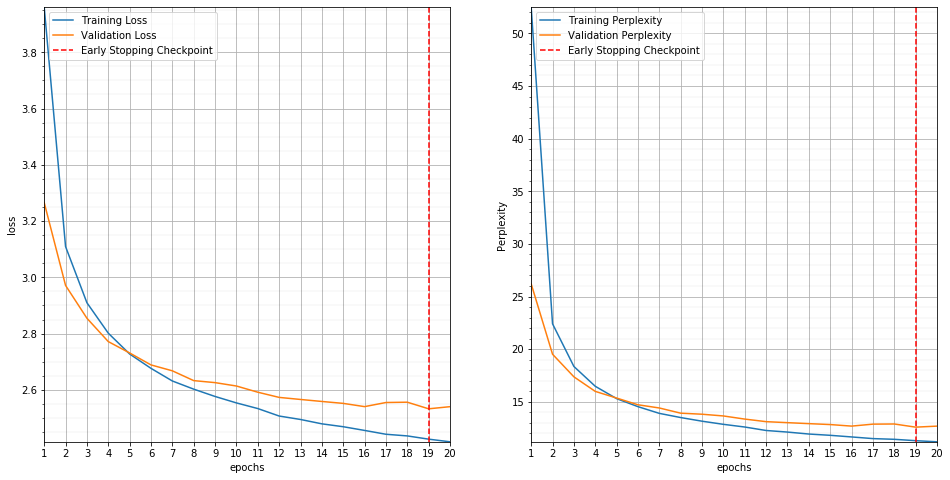

In [37]:
import matplotlib.ticker as ticker
# график трейн- и вал- лоссов
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
#fig = plt.figure(figsize=(10,8))
ax1.plot(range(1,len(train_losses_mean)+1),train_losses_mean, label='Training Loss')
ax1.plot(range(1,len(val_losses_mean)+1),val_losses_mean,label='Validation Loss')

# точка, где минимум вал-лосса
min_valloss = val_losses_mean.index(min(val_losses_mean))+1 
ax1.axvline(min_valloss, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_xlim(1, len(train_losses_mean)) 
ax1.set_ylim(min(train_losses_mean), max(train_losses_mean)) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1.grid(which='minor', color = 'black', linewidth = 0.05)
ax1.grid(True)
ax1.legend()

# график трейн- и вал- Perplexity
ax2.plot(range(1,len(train_perplexes_mean)+1),train_perplexes_mean, label='Training Perplexity')
ax2.plot(range(1,len(val_perplexes_mean)+1),val_perplexes_mean,label='Validation Perplexity')

ax2.axvline(min_valloss, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Perplexity')
ax2.set_xlim(1, len(train_perplexes_mean)) 
ax2.set_ylim(min(train_perplexes_mean), max(train_perplexes_mean)) 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax2.grid(which='minor', color = 'black', linewidth = 0.05)
ax2.grid(True)
ax2.legend()


plt.show()

### Скачаем пару картинок, чтобы проверить качество:

In [38]:
#Подгрузим модель с лучшими результатами (с наименьшим loss при валидации)
network.load_state_dict(torch.load(NET_SAVE_DIR+'checkpoint.pt', map_location=torch.device(device))) 


<All keys matched successfully>

(299, 299, 3)


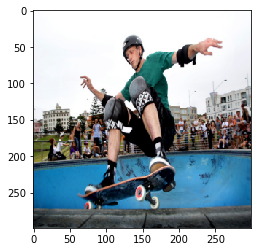

A man in a black shirt doing a trick on a skateboard.
A man doing a trick on a skateboard on a ramp.
A man is doing a trick on a skateboard
A man doing a trick on a skateboard on a ramp.
A man is doing a trick on a skateboard.
A man on a skateboard doing a trick in the air.
A man doing a trick on a skateboard in a park.
A man riding a skateboard up the side of a ramp.
A man riding a skateboard up the side of a ramp.
A man riding a skateboard up the side of a ramp.


In [691]:
img = plt.imread(IMG_TEST_DIR + '12-tony-hawk.w710.h473.jpg')
img = resize(img, (const_resize, const_resize)) 
print(img.shape)
plt.imshow(img)
plt.show()
for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., sample=True, max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

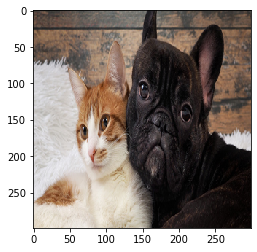

A cat laying on a couch with a remote control in it's mouth.
A dog laying on a couch with a cat on its back
A cat is sitting on a couch with a remote.
A cat with a tag on its face sitting on a couch
A cat laying on a couch with a remote control
A cat laying on a couch next to a remote control.
A cat laying on a couch with a remote control in it's mouth.
A cat is laying down with a remote control in it's mouth.
A cat laying on a couch with a remote control in it's mouth.
A cat laying on a couch with a red blanket and a red blanket.


In [39]:
img = plt.imread(IMG_TEST_DIR + 'Cat-and-dog-1.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

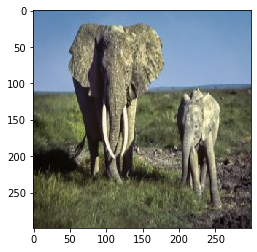

Two elephants standing in a field next to a tree.
A group of elephants walking through a grassy field.
A group of elephants standing in a field.
Two elephants standing in a field with a baby elephant.
A herd of elephants standing on top of a grass covered field.
A group of elephants walking through a grassy field.
A group of elephants standing in a field.
A group of elephants walking through a grassy field.
A herd of elephants walking across a grass covered field.
A group of elephants walking across a grass covered field.


In [694]:
img = plt.imread(IMG_TEST_DIR + 'Elephants.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

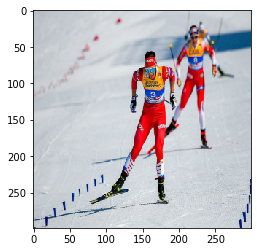

A man riding a pair of skis down a snow covered slope.
A man riding a pair of skis down a snow covered slope.
A man riding a pair of skis down a snow covered slope.
A man riding a pair of skis down a snow covered slope.
A skier is racing down a ski slope.
A man riding skis down a snow covered slope.
A man riding a pair of skis down a snow covered slope.
A man riding skis down a snow covered slope.
A skier is racing down a snowy slope.
A woman in a red jacket skiing down a hill.


In [654]:
img = plt.imread(IMG_TEST_DIR + 'MountSkiers.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

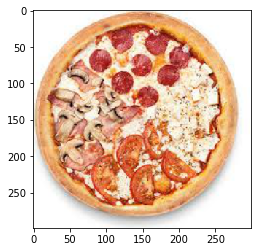

A pizza with several different toppings on it.
A pizza with various toppings on it on a table.
A pizza with lots of toppings on top of it.
A pizza with lots of toppings on top of it.
A pizza with lots of toppings and a fork on a table.
A pizza that is sitting on a table.
A pizza with lots of different toppings on it.
A pizza with lots of toppings on top of it.
A pizza with a lot of cheese and other toppings on it.
A pizza with lots of toppings on top of it.


In [663]:
img = plt.imread(IMG_TEST_DIR + 'pizza.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

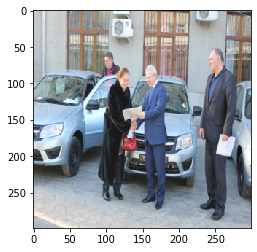

A man in a suit and tie standing in front of a bus.
A man in a suit and tie standing in front of a bus.
A man in a suit and tie standing in front of a bus.
A man standing next to a car on a city street.
A man in a suit and tie standing in a parking lot.
A man in a suit and tie standing next to a train.
A man in a suit and tie standing in front of a bus.
A man in a suit and tie standing in front of a bus.
A man in a suit and tie standing in front of a bus.
A man sitting on a bench in front of a store.


In [41]:
img = plt.imread(IMG_TEST_DIR + 'CarsAndPeople.jpg')
img = resize(img, (const_resize, const_resize))
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

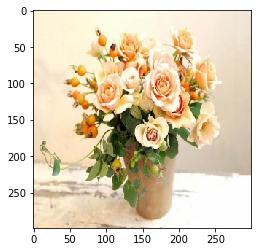

A vase filled with yellow and white flowers.
A vase filled with white and yellow flowers.
A vase filled with yellow and white flowers.
A vase filled with white and yellow flowers.
A vase filled with yellow and white flowers.
A vase filled with yellow flowers on a table.
A vase filled with yellow and white flowers.
A vase filled with yellow and white flowers.
A vase filled with yellow and white flowers.
A vase filled with yellow and white flowers.


In [698]:
img = plt.imread(IMG_TEST_DIR + 'Flowers.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

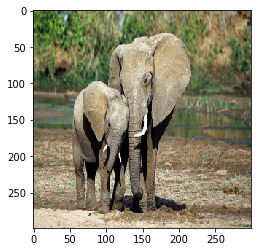

A couple of elephants standing next to each other.
A large elephant standing in a grassy field.
A large elephant standing in a grassy field.
A large elephant standing next to a baby elephant.
An elephant standing in a field next to a forest.
An elephant standing in a field next to a tree.
A baby elephant standing next to a larger elephant.
A large elephant walking through a lush green forest.
An elephant standing in a field next to a tree.
An elephant standing in the middle of a field.


In [699]:
img = plt.imread(IMG_TEST_DIR + 'Elephants_1.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

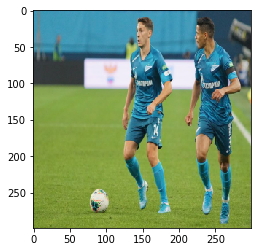

A group of young men playing a game of soccer.
A group of young children playing a game of soccer.
A group of young children playing a game of soccer.
A group of young men playing a game of soccer.
A group of young men playing a game of soccer.
A group of young children playing a game of soccer.
A group of young men playing a game of soccer.
A group of young children playing a game of soccer.
A group of young children kicking a soccer ball around a field.
A group of young men playing a game of soccer.


In [700]:
img = plt.imread(IMG_TEST_DIR + 'Football.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

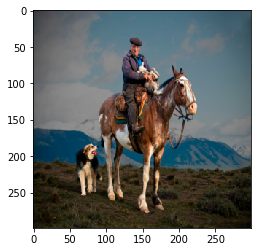

A man riding a horse in a parade
A man riding a horse in a parade
A man riding a horse down a dirt road.
A man riding a horse down a dirt road.
A man riding a horse down a dirt road.
A man riding a horse on top of a dirt field.
A man riding a horse down a dirt road.
A man riding a horse down a dirt road.
A man in a cowboy hat riding a horse
A man riding a horse down a dirt road.


In [661]:
img = plt.imread(IMG_TEST_DIR + 'pastuh-loshad-yagnenok-sobaka.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )

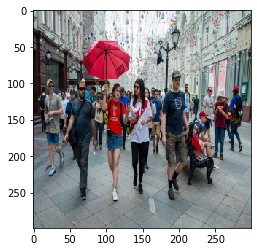

A group of people with umbrellas walking down a street.
A group of people standing on a sidewalk under a red and white umbrella.
A group of people standing on top of a walkway.
A group of people standing around a fire hydrant.
A group of people standing in a room with a large umbrella.
A group of people standing around a fire hydrant.
A group of people standing on a sidewalk holding up umbrellas.
A group of people walking down a street holding umbrellas.
A group of people standing on top of a stone walkway.
A group of people standing on top of a stone walkway.


In [702]:
img = plt.imread(IMG_TEST_DIR + 'Street.jpg')
img = resize(img, (const_resize, const_resize)) 
plt.imshow(img)
plt.show()

for i in range(10):
    caption = generate_caption(network, img, tokens, t=5., max_len=max_caption_len, device=device)[0]
    print(' '.join(caption.split(' ')[1:-1]) )